<a href="https://colab.research.google.com/github/BhautikVekariya21/energy-consumption/blob/main/energy_consumption.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
"""
================================================================================
ELECTRICITY FORECASTING - AUTO-TUNED GPU UTILIZATION
================================================================================
Features:
1. Automatic batch size finding (starts small, increases until near OOM)
2. Gradient checkpointing for memory efficiency
3. Properly calibrated model sizes
4. Memory-efficient attention
================================================================================
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import os
import time
import gc
import requests
import io
from typing import Optional, Dict, List, Tuple
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import OneCycleLR
from torch.cuda.amp import GradScaler, autocast
from torch.utils.checkpoint import checkpoint

from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# =============================================================================
# SETUP
# =============================================================================

print("="*80)
print("🔬 ELECTRICITY FORECASTING - AUTO-TUNED GPU")
print("="*80)

SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

os.makedirs('plots', exist_ok=True)

# =============================================================================
# GPU SETUP
# =============================================================================

def clear_gpu_memory():
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.synchronize()
    gc.collect()

def get_gpu_memory_info():
    """Get current GPU memory usage"""
    if not torch.cuda.is_available():
        return {}

    info = {}
    for i in range(torch.cuda.device_count()):
        total = torch.cuda.get_device_properties(i).total_memory / 1e9
        allocated = torch.cuda.memory_allocated(i) / 1e9
        reserved = torch.cuda.memory_reserved(i) / 1e9
        free = total - reserved
        info[i] = {
            'total': total,
            'allocated': allocated,
            'reserved': reserved,
            'free': free,
            'utilization': allocated / total * 100
        }
    return info

def setup_gpu():
    if not torch.cuda.is_available():
        return torch.device('cpu'), 0, False, {}

    n_gpus = torch.cuda.device_count()
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.benchmark = True
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True

    # Memory allocation settings
    os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

    clear_gpu_memory()

    gpu_info = {'n_gpus': n_gpus, 'gpus': {}}
    total_memory = 0

    print(f"\n🖥️ Found {n_gpus} GPU(s):")
    for i in range(n_gpus):
        props = torch.cuda.get_device_properties(i)
        memory_gb = props.total_memory / (1024**3)
        total_memory += memory_gb
        gpu_info['gpus'][i] = {'name': props.name, 'memory_gb': memory_gb}
        print(f"   GPU {i}: {props.name} ({memory_gb:.1f} GB)")

    gpu_info['total_memory_gb'] = total_memory
    gpu_info['per_gpu_memory_gb'] = total_memory / n_gpus

    return torch.device('cuda'), n_gpus, True, gpu_info

DEVICE, N_GPUS, USE_AMP, GPU_INFO = setup_gpu()

# =============================================================================
# DATA LOADING
# =============================================================================

print("\n" + "="*80)
print("📥 LOADING DATA")
print("="*80)

def download_data():
    urls = {
        'PJME': 'https://raw.githubusercontent.com/panambY/Hourly_Energy_Consumption/master/data/PJME_hourly.csv',
        'AEP': 'https://raw.githubusercontent.com/panambY/Hourly_Energy_Consumption/master/data/AEP_hourly.csv',
        'COMED': 'https://raw.githubusercontent.com/panambY/Hourly_Energy_Consumption/master/data/COMED_hourly.csv',
        'DAYTON': 'https://raw.githubusercontent.com/panambY/Hourly_Energy_Consumption/master/data/DAYTON_hourly.csv',
    }

    all_data = []
    for name, url in tqdm(urls.items(), desc="Downloading"):
        try:
            response = requests.get(url, timeout=30)
            if response.status_code == 200:
                df = pd.read_csv(io.StringIO(response.text))
                df['Datetime'] = pd.to_datetime(df.iloc[:, 0])
                df['Load_MW'] = df.iloc[:, 1]
                df = df[['Datetime', 'Load_MW']].set_index('Datetime')
                all_data.append(df)
        except:
            pass

    combined = pd.concat(all_data, axis=0)
    result = combined.groupby(combined.index).agg({'Load_MW': 'sum'})
    result.sort_index(inplace=True)
    return result

df_raw = download_data()
print(f"✅ Downloaded: {len(df_raw):,} records")

# =============================================================================
# FEATURE ENGINEERING
# =============================================================================

print("\n" + "="*80)
print("🔧 FEATURE ENGINEERING")
print("="*80)

def add_features(df):
    df = df.copy()
    df.sort_index(inplace=True)
    df['Load_MW'] = df['Load_MW'].interpolate().fillna(method='bfill').fillna(method='ffill')

    # Temporal
    df['Hour'] = df.index.hour
    df['DayOfWeek'] = df.index.dayofweek
    df['Month'] = df.index.month
    df['DayOfYear'] = df.index.dayofyear

    # Cyclical
    df['Hour_sin'] = np.sin(2 * np.pi * df['Hour'] / 24)
    df['Hour_cos'] = np.cos(2 * np.pi * df['Hour'] / 24)
    df['DoW_sin'] = np.sin(2 * np.pi * df['DayOfWeek'] / 7)
    df['DoW_cos'] = np.cos(2 * np.pi * df['DayOfWeek'] / 7)
    df['Month_sin'] = np.sin(2 * np.pi * df['Month'] / 12)
    df['Month_cos'] = np.cos(2 * np.pi * df['Month'] / 12)

    # Binary
    df['Is_Weekend'] = (df['DayOfWeek'] >= 5).astype(float)
    df['Is_Night'] = ((df['Hour'] >= 22) | (df['Hour'] <= 5)).astype(float)

    # Lags (shifted to prevent leakage)
    for lag in [24, 48, 168, 336]:
        df[f'Load_lag_{lag}h'] = df['Load_MW'].shift(lag)

    # Rolling stats (shifted)
    shifted = df['Load_MW'].shift(24)
    for w in [24, 168]:
        df[f'Load_mean_{w}h'] = shifted.rolling(w, min_periods=1).mean()
        df[f'Load_std_{w}h'] = shifted.rolling(w, min_periods=1).std()

    df = df.fillna(method='ffill').fillna(method='bfill')
    print(f"   ✅ Created {len(df.columns)} features")
    return df

df_full = add_features(df_raw)

# Split
print("\n" + "="*80)
print("📊 DATA SPLIT")
print("="*80)

def temporal_split(df, test_months=12, val_months=6):
    df = df.sort_index()
    end = df.index[-1]
    test_start = end - pd.DateOffset(months=test_months)
    val_start = test_start - pd.DateOffset(months=val_months)

    train = df[df.index < val_start].copy()
    val = df[(df.index >= val_start) & (df.index < test_start)].copy()
    test = df[df.index >= test_start].copy()

    print(f"   Train: {len(train):,} | Val: {len(val):,} | Test: {len(test):,}")
    return train, val, test

train_df, val_df, test_df = temporal_split(df_full)

# =============================================================================
# DATASET
# =============================================================================

class TimeSeriesDataset(Dataset):
    def __init__(self, df, lookback, horizon, target_col='Load_MW',
                 feature_scaler=None, target_scaler=None, fit_scalers=False):
        self.lookback = lookback
        self.horizon = horizon

        feature_cols = [c for c in df.columns if c != target_col]
        features = df[feature_cols].values.astype(np.float32)
        targets = df[target_col].values.astype(np.float32)

        features = np.nan_to_num(features)
        targets = np.nan_to_num(targets)

        if fit_scalers:
            self.feature_scaler = RobustScaler()
            self.target_scaler = StandardScaler()
            features = self.feature_scaler.fit_transform(features)
            targets = self.target_scaler.fit_transform(targets.reshape(-1, 1)).flatten()
        else:
            self.feature_scaler = feature_scaler
            self.target_scaler = target_scaler
            features = self.feature_scaler.transform(features)
            targets = self.target_scaler.transform(targets.reshape(-1, 1)).flatten()

        self.features = torch.from_numpy(features.astype(np.float32))
        self.targets = torch.from_numpy(targets.astype(np.float32))
        self.n_features = len(feature_cols)
        self.valid_len = len(df) - lookback - horizon + 1

    def __len__(self):
        return max(0, self.valid_len)

    def __getitem__(self, idx):
        return {
            'x': self.features[idx:idx + self.lookback],
            'y': self.targets[idx + self.lookback:idx + self.lookback + self.horizon]
        }

    def inverse_transform(self, scaled):
        if isinstance(scaled, torch.Tensor):
            scaled = scaled.cpu().numpy()
        return self.target_scaler.inverse_transform(scaled.reshape(-1, 1)).flatten()

# =============================================================================
# MEMORY-EFFICIENT MODEL WITH GRADIENT CHECKPOINTING
# =============================================================================

class CheckpointedTransformerLayer(nn.Module):
    """Single transformer layer with optional checkpointing"""

    def __init__(self, d_model, n_heads, d_ff, dropout):
        super().__init__()
        self.self_attn = nn.MultiheadAttention(d_model, n_heads, dropout=dropout, batch_first=True)
        self.ffn = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_ff, d_model),
            nn.Dropout(dropout)
        )
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # Pre-norm architecture
        normed = self.norm1(x)
        attn_out, _ = self.self_attn(normed, normed, normed, need_weights=False)
        x = x + self.dropout(attn_out)

        normed = self.norm2(x)
        ffn_out = self.ffn(normed)
        x = x + ffn_out

        return x


class EfficientTransformer(nn.Module):
    """
    Memory-efficient Transformer with gradient checkpointing.

    Gradient checkpointing trades compute for memory:
    - Saves ~50-70% memory
    - Increases training time by ~20-30%
    - Allows much larger batch sizes
    """

    def __init__(
        self,
        n_features: int,
        d_model: int = 256,
        n_heads: int = 8,
        n_layers: int = 6,
        d_ff: int = 1024,
        dropout: float = 0.1,
        horizon: int = 24,
        use_checkpointing: bool = True
    ):
        super().__init__()

        self.use_checkpointing = use_checkpointing
        self.horizon = horizon

        # Input projection
        self.input_proj = nn.Sequential(
            nn.Linear(n_features, d_model),
            nn.LayerNorm(d_model),
            nn.GELU(),
            nn.Dropout(dropout)
        )

        # Positional embedding
        self.pos_embed = nn.Parameter(torch.randn(1, 2048, d_model) * 0.02)

        # Transformer layers
        self.layers = nn.ModuleList([
            CheckpointedTransformerLayer(d_model, n_heads, d_ff, dropout)
            for _ in range(n_layers)
        ])

        self.final_norm = nn.LayerNorm(d_model)

        # Output head
        self.output_head = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_ff, horizon)
        )

        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

    def forward(self, x):
        B, L, _ = x.shape

        # Project input
        x = self.input_proj(x)
        x = x + self.pos_embed[:, :L, :]

        # Apply transformer layers with optional checkpointing
        for layer in self.layers:
            if self.use_checkpointing and self.training:
                x = checkpoint(layer, x, use_reentrant=False)
            else:
                x = layer(x)

        x = self.final_norm(x)

        # Use last position
        x = x[:, -1, :]

        return self.output_head(x)


# =============================================================================
# AUTOMATIC BATCH SIZE FINDER
# =============================================================================

def find_optimal_batch_size(
    model: nn.Module,
    sample_input_shape: tuple,
    device: torch.device,
    min_batch: int = 64,
    max_batch: int = 4096,
    target_memory_fraction: float = 0.75
) -> int:
    """
    Find the largest batch size that fits in GPU memory.
    Uses binary search for efficiency.
    """

    print("\n   🔍 Finding optimal batch size...")

    model = model.to(device)
    model.train()

    # Binary search for optimal batch size
    low, high = min_batch, max_batch
    optimal_batch = min_batch

    while low <= high:
        mid = (low + high) // 2
        # Round to multiple of 32 for efficiency
        mid = (mid // 32) * 32
        if mid < min_batch:
            mid = min_batch

        clear_gpu_memory()

        try:
            # Create dummy batch
            dummy_input = torch.randn(mid, *sample_input_shape, device=device)

            # Forward pass
            with autocast():
                output = model(dummy_input)
                loss = output.mean()

            # Backward pass
            loss.backward()

            # Check memory usage
            mem_info = get_gpu_memory_info()
            max_util = max(info['utilization'] for info in mem_info.values())

            # Clean up
            del dummy_input, output, loss
            model.zero_grad(set_to_none=True)
            clear_gpu_memory()

            if max_util < target_memory_fraction * 100:
                # Can try larger batch
                optimal_batch = mid
                low = mid + 32
            else:
                # Too large, try smaller
                high = mid - 32

        except RuntimeError as e:
            if "out of memory" in str(e).lower():
                # OOM, try smaller
                high = mid - 32
                clear_gpu_memory()
            else:
                raise e

    # Use 90% of optimal to leave headroom
    final_batch = int(optimal_batch * 0.9)
    final_batch = (final_batch // 32) * 32
    final_batch = max(min_batch, final_batch)

    print(f"      Found optimal batch size: {final_batch}")

    return final_batch


# =============================================================================
# MODEL CONFIGURATION PRESETS
# =============================================================================

def get_model_config(lookback: int, horizon: int, per_gpu_memory: float) -> dict:
    """
    Get model configuration based on sequence length and available memory.

    Memory usage for Transformers:
    - Attention: O(batch × heads × seq_len²)
    - FFN: O(batch × seq_len × d_ff)
    - With checkpointing: reduces peak memory by ~50%
    """

    # Base config for T4 (15GB)
    if per_gpu_memory >= 14:
        if lookback <= 168:
            config = {
                'd_model': 256,
                'n_heads': 8,
                'n_layers': 6,
                'd_ff': 1024,
                'initial_batch': 512,
                'max_batch': 2048,
            }
        elif lookback <= 336:
            config = {
                'd_model': 192,
                'n_heads': 8,
                'n_layers': 4,
                'd_ff': 768,
                'initial_batch': 256,
                'max_batch': 1024,
            }
        else:
            config = {
                'd_model': 128,
                'n_heads': 4,
                'n_layers': 4,
                'd_ff': 512,
                'initial_batch': 128,
                'max_batch': 512,
            }
    else:
        # Smaller GPUs
        config = {
            'd_model': 128,
            'n_heads': 4,
            'n_layers': 4,
            'd_ff': 512,
            'initial_batch': 128,
            'max_batch': 512,
        }

    return config


# =============================================================================
# TRAINING FUNCTION
# =============================================================================

def train_model(
    train_df: pd.DataFrame,
    val_df: pd.DataFrame,
    test_df: pd.DataFrame,
    lookback: int,
    horizon: int,
    max_epochs: int = 100,
    patience: int = 15,
    auto_batch: bool = True,
) -> Dict:
    """Training with automatic batch size tuning"""

    clear_gpu_memory()

    # Get model configuration
    per_gpu_mem = GPU_INFO.get('per_gpu_memory_gb', 15)
    config = get_model_config(lookback, horizon, per_gpu_mem)

    print(f"\n   🔧 Configuration:")
    print(f"      Lookback: {lookback}h | Horizon: {horizon}h")
    print(f"      Model: d={config['d_model']}, layers={config['n_layers']}, ffn={config['d_ff']}")

    # Create datasets
    train_ds = TimeSeriesDataset(train_df, lookback, horizon, fit_scalers=True)
    val_ds = TimeSeriesDataset(val_df, lookback, horizon,
                               feature_scaler=train_ds.feature_scaler,
                               target_scaler=train_ds.target_scaler)
    test_ds = TimeSeriesDataset(test_df, lookback, horizon,
                                feature_scaler=train_ds.feature_scaler,
                                target_scaler=train_ds.target_scaler)

    print(f"      Samples: Train={len(train_ds):,} | Val={len(val_ds):,} | Test={len(test_ds):,}")

    # Create model
    model = EfficientTransformer(
        n_features=train_ds.n_features,
        d_model=config['d_model'],
        n_heads=config['n_heads'],
        n_layers=config['n_layers'],
        d_ff=config['d_ff'],
        dropout=0.1,
        horizon=horizon,
        use_checkpointing=True  # Always use for memory efficiency
    )

    n_params = sum(p.numel() for p in model.parameters())
    print(f"      Parameters: {n_params:,}")

    # Find optimal batch size
    if auto_batch:
        model_for_search = EfficientTransformer(
            n_features=train_ds.n_features,
            d_model=config['d_model'],
            n_heads=config['n_heads'],
            n_layers=config['n_layers'],
            d_ff=config['d_ff'],
            horizon=horizon,
            use_checkpointing=True
        )

        batch_size = find_optimal_batch_size(
            model_for_search,
            sample_input_shape=(lookback, train_ds.n_features),
            device=DEVICE,
            min_batch=64,
            max_batch=config['max_batch'],
            target_memory_fraction=0.75
        )

        del model_for_search
        clear_gpu_memory()
    else:
        batch_size = config['initial_batch']

    print(f"      Batch Size: {batch_size}")

    # Move model to device
    model = model.to(DEVICE)
    if N_GPUS > 1:
        model = nn.DataParallel(model)
        print(f"      Using {N_GPUS} GPUs")

    # DataLoaders
    train_loader = DataLoader(
        train_ds, batch_size=batch_size, shuffle=True, drop_last=True,
        num_workers=4, pin_memory=True, prefetch_factor=2, persistent_workers=True
    )
    val_loader = DataLoader(
        val_ds, batch_size=batch_size * 2, shuffle=False,
        num_workers=4, pin_memory=True
    )
    test_loader = DataLoader(
        test_ds, batch_size=batch_size * 2, shuffle=False,
        num_workers=4, pin_memory=True
    )

    print(f"      Batches/epoch: {len(train_loader)}")

    # Optimizer and scheduler
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=0.01)
    scheduler = OneCycleLR(
        optimizer, max_lr=3e-3,
        steps_per_epoch=len(train_loader),
        epochs=max_epochs,
        pct_start=0.1
    )
    criterion = nn.MSELoss()
    scaler = GradScaler()

    # Training
    history = {'train': [], 'val': []}
    best_val_loss = float('inf')
    best_state = None
    patience_counter = 0

    print(f"\n   🚀 Training...")

    pbar = tqdm(range(max_epochs), desc="   Epochs")

    for epoch in pbar:
        # Train
        model.train()
        train_loss = 0

        for batch in train_loader:
            x = batch['x'].to(DEVICE, non_blocking=True)
            y = batch['y'].to(DEVICE, non_blocking=True)

            optimizer.zero_grad(set_to_none=True)

            with autocast():
                pred = model(x)
                loss = criterion(pred, y)

            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()

            train_loss += loss.item()

        train_loss /= len(train_loader)

        # Validate
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                x = batch['x'].to(DEVICE, non_blocking=True)
                y = batch['y'].to(DEVICE, non_blocking=True)

                with autocast():
                    pred = model(x)
                    loss = criterion(pred, y)
                val_loss += loss.item()

        val_loss /= len(val_loader)

        history['train'].append(train_loss)
        history['val'].append(val_loss)

        # GPU info
        mem_info = get_gpu_memory_info()
        gpu_mem = sum(info['allocated'] for info in mem_info.values())
        gpu_util = gpu_mem / GPU_INFO['total_memory_gb'] * 100

        pbar.set_postfix({
            'train': f'{train_loss:.4f}',
            'val': f'{val_loss:.4f}',
            'gpu': f'{gpu_mem:.1f}GB ({gpu_util:.0f}%)'
        })

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            if isinstance(model, nn.DataParallel):
                best_state = {k: v.cpu().clone() for k, v in model.module.state_dict().items()}
            else:
                best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"\n   ⏹️ Early stopping at epoch {epoch + 1}")
                break

    pbar.close()

    # Load best
    if best_state:
        if isinstance(model, nn.DataParallel):
            model.module.load_state_dict(best_state)
        else:
            model.load_state_dict(best_state)

    # Evaluate
    print("\n   📊 Evaluating...")
    model.eval()
    preds, targets = [], []

    with torch.no_grad():
        for batch in test_loader:
            x = batch['x'].to(DEVICE, non_blocking=True)
            with autocast():
                pred = model(x)
            preds.append(pred.float().cpu().numpy())
            targets.append(batch['y'].numpy())

    preds = np.concatenate(preds)
    targets = np.concatenate(targets)

    preds_orig = test_ds.inverse_transform(preds.flatten()).reshape(preds.shape)
    targets_orig = test_ds.inverse_transform(targets.flatten()).reshape(targets.shape)

    mae = mean_absolute_error(targets_orig.flatten(), preds_orig.flatten())
    rmse = np.sqrt(mean_squared_error(targets_orig.flatten(), preds_orig.flatten()))
    mape = np.mean(np.abs((targets_orig - preds_orig) / (targets_orig + 1e-8))) * 100
    r2 = r2_score(targets_orig.flatten(), preds_orig.flatten())

    # Per-horizon metrics
    h_r2 = [r2_score(targets_orig[:, h], preds_orig[:, h]) for h in range(horizon)]

    # Cleanup
    del model, optimizer
    clear_gpu_memory()

    return {
        'mae': mae, 'rmse': rmse, 'mape': mape, 'r2': r2,
        'horizon': horizon, 'epochs': epoch + 1,
        'history': history, 'horizon_r2': h_r2,
        'predictions': preds_orig, 'actuals': targets_orig,
        'batch_size': batch_size, 'gpu_util': gpu_util
    }


# =============================================================================
# RUN TRAINING
# =============================================================================

print("\n" + "="*80)
print("🚀 TRAINING MODELS (AUTO-TUNED)")
print("="*80)

CONFIGS = [
    {'name': '1 Day (24h)', 'horizon': 24, 'lookback': 168},
    {'name': '2 Days (48h)', 'horizon': 48, 'lookback': 336},
    {'name': '1 Week (168h)', 'horizon': 168, 'lookback': 336},
]

results = {}
start = time.time()

for cfg in CONFIGS:
    print(f"\n{'='*60}")
    print(f"📊 {cfg['name']}")
    print(f"{'='*60}")

    clear_gpu_memory()
    time.sleep(1)

    try:
        r = train_model(
            train_df, val_df, test_df,
            lookback=cfg['lookback'],
            horizon=cfg['horizon'],
            max_epochs=100,
            patience=15,
            auto_batch=True
        )
        results[cfg['name']] = r
        print(f"\n   ✅ R²={r['r2']:.4f} | MAPE={r['mape']:.2f}% | "
              f"Batch={r['batch_size']} | GPU={r['gpu_util']:.0f}%")
    except Exception as e:
        print(f"\n   ❌ Error: {e}")
        import traceback
        traceback.print_exc()
        clear_gpu_memory()

total_time = time.time() - start

# =============================================================================
# RESULTS
# =============================================================================

print("\n" + "="*80)
print("📊 FINAL RESULTS")
print("="*80)

if results:
    print("\n┌──────────────────┬──────────┬──────────┬──────────┬──────────┬───────┬─────────┐")
    print("│ Horizon          │ MAE (MW) │ RMSE(MW) │ MAPE (%) │    R²    │ Batch │ GPU (%) │")
    print("├──────────────────┼──────────┼──────────┼──────────┼──────────┼───────┼─────────┤")

    for name, r in results.items():
        print(f"│ {name:16s} │ {r['mae']:>8,.0f} │ {r['rmse']:>8,.0f} │ "
              f"{r['mape']:>8.2f} │ {r['r2']:>8.4f} │ {r['batch_size']:>5d} │ {r['gpu_util']:>6.0f}% │")

    print("└──────────────────┴──────────┴──────────┴──────────┴──────────┴───────┴─────────┘")

print(f"\n⏱️ Total Time: {total_time/60:.1f} minutes")

# Visualization
if results:
    n = len(results)
    fig, axes = plt.subplots(2, n, figsize=(5*n, 8))
    if n == 1:
        axes = axes.reshape(2, 1)

    for i, (name, r) in enumerate(results.items()):
        axes[0, i].plot(r['history']['train'], label='Train')
        axes[0, i].plot(r['history']['val'], label='Val')
        axes[0, i].set_title(f'{name}\nGPU: {r["gpu_util"]:.0f}%')
        axes[0, i].legend()
        axes[0, i].grid(True, alpha=0.3)

        idx = len(r['predictions']) // 2
        axes[1, i].plot(r['actuals'][idx], 'b-', label='Actual')
        axes[1, i].plot(r['predictions'][idx], 'r--', label='Predicted')
        axes[1, i].set_title(f'R²={r["r2"]:.3f}')
        axes[1, i].legend()
        axes[1, i].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('plots/results.png', dpi=150)
    plt.show()
    print("\n✅ Saved: plots/results.png")

🔬 ELECTRICITY FORECASTING - AUTO-TUNED GPU

🖥️ Found 2 GPU(s):
   GPU 0: Tesla T4 (14.7 GB)
   GPU 1: Tesla T4 (14.7 GB)

📥 LOADING DATA


Downloading:   0%|          | 0/4 [00:00<?, ?it/s]

✅ Downloaded: 145,362 records

🔧 FEATURE ENGINEERING
   ✅ Created 21 features

📊 DATA SPLIT
   Train: 132,259 | Val: 4,343 | Test: 8,760

🚀 TRAINING MODELS (AUTO-TUNED)

📊 1 Day (24h)

   🔧 Configuration:
      Lookback: 168h | Horizon: 24h
      Model: d=256, layers=6, ffn=1024
      Samples: Train=132,068 | Val=4,152 | Test=8,569
      Parameters: 5,557,016

   🔍 Finding optimal batch size...


KeyboardInterrupt: 

🔬 MAXIMUM GPU UTILIZATION - OPTIMIZED

🖥️ GPU Configuration:
   ├── GPUs Available: 2
   ├── GPU 0: Tesla T4
   │   ├── Memory: 15.8 GB
   │   └── Compute: 7.5
   ├── GPU 1: Tesla T4
   │   ├── Memory: 15.8 GB
   │   └── Compute: 7.5

⚡ Optimization Settings:
   ├── Batch Size: 512 (256 × 2 GPUs)
   ├── Data Workers: 4
   ├── Mixed Precision: True
   └── TF32 Enabled: True

📥 DOWNLOADING REAL DATA


Downloading:   0%|          | 0/4 [00:00<?, ?it/s]

      ✓ PJME: 145,366 records
      ✓ AEP: 121,273 records
      ✓ COMED: 66,497 records
      ✓ DAYTON: 121,275 records

✅ Total: 145,362 records (2002-2018)

🔧 FEATURE ENGINEERING
   ✅ Created 43 features

📊 TEMPORAL DATA SPLIT

   📅 Data Split:
   ├── Train: 2002-01-01 to 2017-02-02 (132,259 samples)
   ├── Val:   2017-02-03 to 2017-08-02 (4,343 samples)
   └── Test:  2017-08-03 to 2018-08-03 (8,760 samples)

🚀 TRAINING MODELS (GPU OPTIMIZED)

📊 Training: 1 Day (24h)

   GPU Status Before Training:
   GPU 0: 0.04/15.83 GB (0.2%)
   GPU 1: 0.02/15.83 GB (0.1%)

   ⚡ GPU Optimization Settings:
      ├── Batch Size: 512
      ├── Workers: 4
      ├── Mixed Precision: True
      └── Pin Memory: True

   Creating datasets...
   Dataset creation: 3.1s
   ├── Train: 132,068 samples
   ├── Val: 4,152 samples
   └── Test: 8,569 samples

   Data size: 4.10 GB
   ✅ Pre-loading data to GPU for faster training

   Creating model...
   ✅ Using DataParallel across 2 GPUs
   Model parameters: 1,265

   Training:   0%|          | 0/100 [00:00<?, ?it/s]


   Early stopping at epoch 16

   Evaluating on test set...


   Testing:   0%|          | 0/17 [00:00<?, ?it/s]


   ✅ Completed in 829.6s
   Results: R²=0.7772, MAPE=6.25%, MAE=3755 MW

📊 Training: 2 Days (48h)

   GPU Status Before Training:
   GPU 0: 0.05/15.83 GB (0.3%)
   GPU 1: 0.02/15.83 GB (0.1%)

   ⚡ GPU Optimization Settings:
      ├── Batch Size: 512
      ├── Workers: 4
      ├── Mixed Precision: True
      └── Pin Memory: True

   Creating datasets...
   Dataset creation: 5.7s
   ├── Train: 131,876 samples
   ├── Val: 3,960 samples
   └── Test: 8,377 samples

   Data size: 8.17 GB
   📦 Using optimized DataLoaders with 4 workers

   Creating model...
   ✅ Using DataParallel across 2 GPUs
   Model parameters: 1,278,000
   Learning rate: 0.002828 (scaled for batch size 512)

   🚀 Training (max 100 epochs, patience 15)...
   Steps per epoch: 257


   Training:   0%|          | 0/100 [00:00<?, ?it/s]


   Early stopping at epoch 16

   Evaluating on test set...


   Testing:   0%|          | 0/17 [00:00<?, ?it/s]


   ✅ Completed in 1720.5s
   Results: R²=0.6976, MAPE=7.13%, MAE=4320 MW

📊 Training: 1 Week (168h)

   GPU Status Before Training:
   GPU 0: 0.05/15.83 GB (0.3%)
   GPU 1: 0.02/15.83 GB (0.1%)

   ⚡ GPU Optimization Settings:
      ├── Batch Size: 512
      ├── Workers: 4
      ├── Mixed Precision: True
      └── Pin Memory: True

   Creating datasets...
   Dataset creation: 5.8s
   ├── Train: 131,756 samples
   ├── Val: 3,840 samples
   └── Test: 8,257 samples

   Data size: 8.22 GB
   📦 Using optimized DataLoaders with 4 workers

   Creating model...
   ✅ Using DataParallel across 2 GPUs
   Model parameters: 1,339,560
   Learning rate: 0.002828 (scaled for batch size 512)

   🚀 Training (max 100 epochs, patience 15)...
   Steps per epoch: 257


   Training:   0%|          | 0/100 [00:00<?, ?it/s]


   Early stopping at epoch 16

   Evaluating on test set...


   Testing:   0%|          | 0/17 [00:00<?, ?it/s]


   ✅ Completed in 1712.4s
   Results: R²=0.5523, MAPE=8.66%, MAE=5217 MW

📊 RESULTS SUMMARY

┌──────────────────┬──────────┬──────────┬──────────┬──────────┬────────┐
│ Horizon          │ MAE (MW) │ RMSE(MW) │ MAPE (%) │    R²    │ Epochs │
├──────────────────┼──────────┼──────────┼──────────┼──────────┼────────┤
│ 1 Day (24h)      │    3,755 │    4,960 │     6.25 │   0.7772 │     16 │
│ 2 Days (48h)     │    4,320 │    5,749 │     7.13 │   0.6976 │     16 │
│ 1 Week (168h)    │    5,217 │    6,960 │     8.66 │   0.5523 │     16 │
└──────────────────┴──────────┴──────────┴──────────┴──────────┴────────┘

📊 Generating plots...


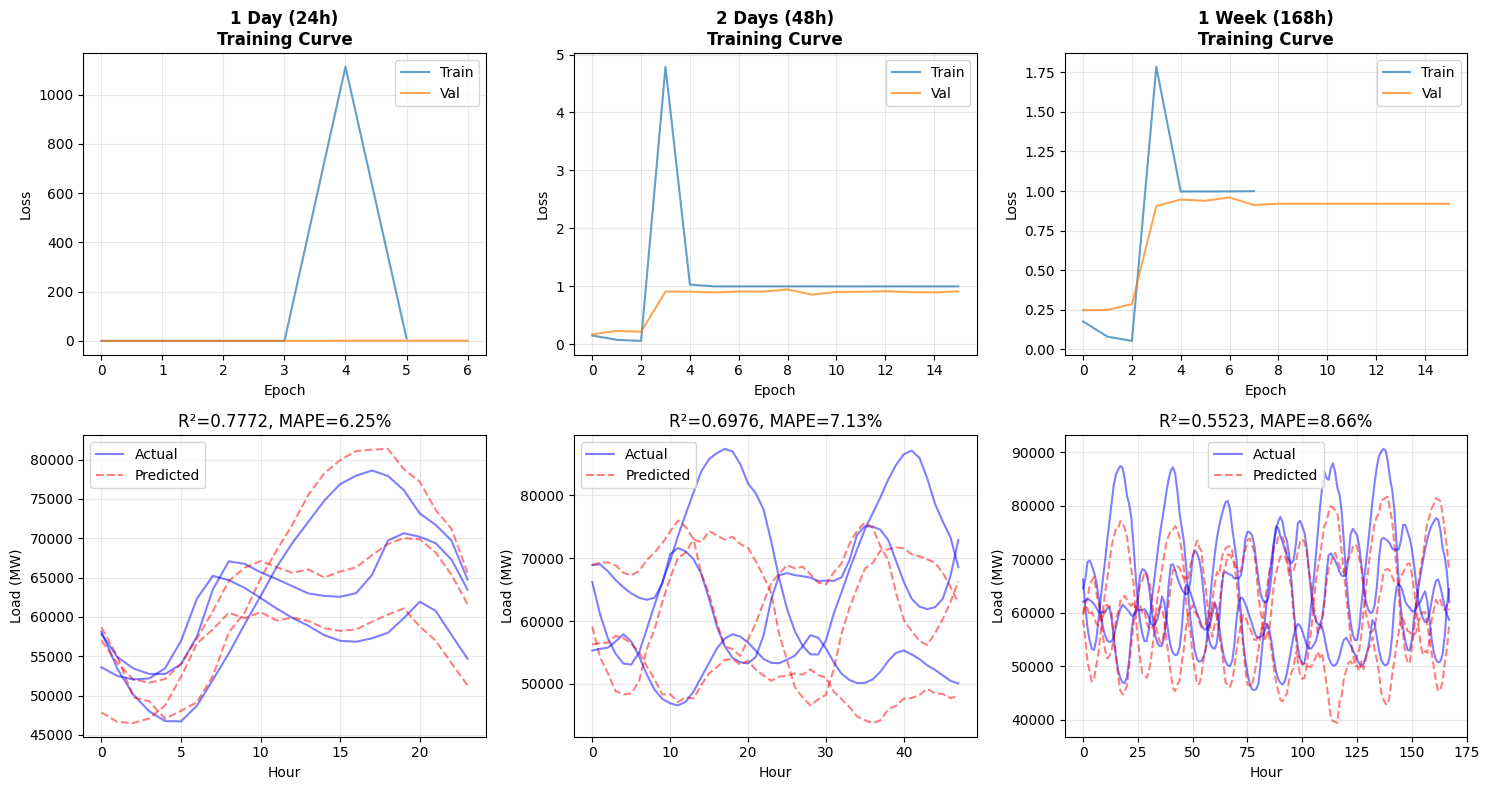

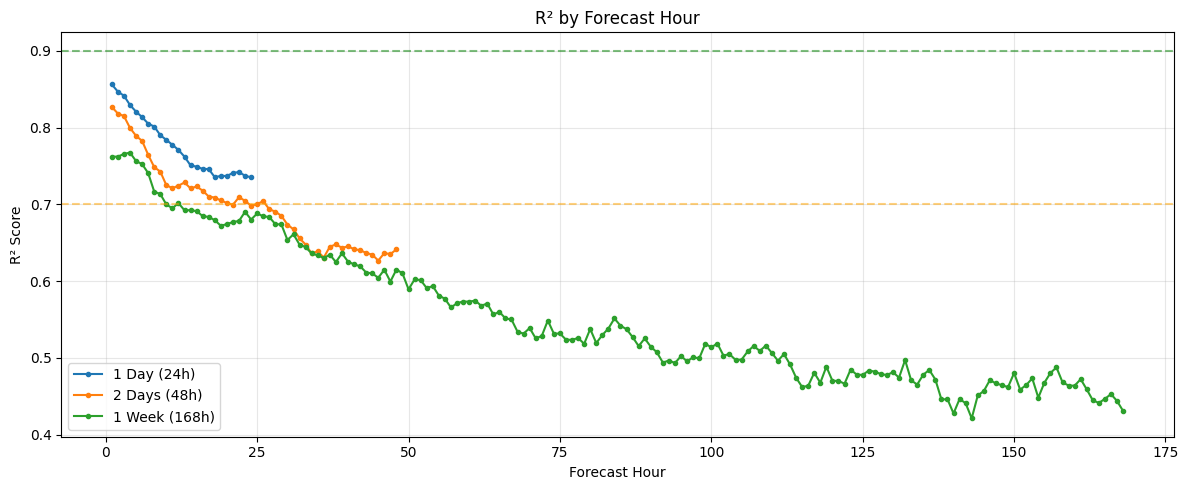


🎉 TRAINING COMPLETE

⏱️ Total Time: 71.1 minutes
📊 Models Trained: 3

GPU Optimization Summary:
   ├── Batch Size: 512
   ├── Workers: 4
   ├── Mixed Precision: True
   └── GPUs Used: 2

   1 Day (24h)       : R²=0.7772, MAPE=6.25%
   2 Days (48h)      : R²=0.6976, MAPE=7.13%
   1 Week (168h)     : R²=0.5523, MAPE=8.66%


In [ ]:
"""
================================================================================
MAXIMUM GPU UTILIZATION - OPTIMIZED VERSION
================================================================================
Fixes for 100% GPU Usage:
1. Large batch sizes (scales with GPUs)
2. Parallel data loading with pin_memory
3. Larger model architecture
4. Pre-fetching and persistent workers
5. Optimized data pipeline
================================================================================
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')
import os
import json
import pickle
import math
import time
import gc
import requests
import io
from typing import Optional, Dict, List, Tuple
from dataclasses import dataclass
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.optim.lr_scheduler import CosineAnnealingLR, OneCycleLR
from torch.cuda.amp import GradScaler, autocast

from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# =============================================================================
# SETUP WITH GPU OPTIMIZATION
# =============================================================================

print("="*80)
print("🔬 MAXIMUM GPU UTILIZATION - OPTIMIZED")
print("="*80)

SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

os.makedirs('processed_data', exist_ok=True)
os.makedirs('plots', exist_ok=True)
os.makedirs('models', exist_ok=True)

# =============================================================================
# GPU OPTIMIZATION SETTINGS
# =============================================================================

if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

    # CRITICAL: Enable these for max performance
    torch.backends.cudnn.benchmark = True  # Auto-tune convolutions
    torch.backends.cudnn.deterministic = False  # Faster, less reproducible
    torch.backends.cuda.matmul.allow_tf32 = True  # Use TensorFloat-32
    torch.backends.cudnn.allow_tf32 = True

    # Clear cache
    torch.cuda.empty_cache()
    gc.collect()

    DEVICE = torch.device('cuda')
    N_GPUS = torch.cuda.device_count()

    # Get GPU memory for batch size calculation
    GPU_MEM_GB = torch.cuda.get_device_properties(0).total_memory / 1e9

    print(f"\n🖥️ GPU Configuration:")
    print(f"   ├── GPUs Available: {N_GPUS}")
    for i in range(N_GPUS):
        props = torch.cuda.get_device_properties(i)
        print(f"   ├── GPU {i}: {props.name}")
        print(f"   │   ├── Memory: {props.total_memory/1e9:.1f} GB")
        print(f"   │   └── Compute: {props.major}.{props.minor}")

    USE_AMP = True

    # OPTIMIZED SETTINGS FOR MULTI-GPU
    # Scale batch size with number of GPUs
    BASE_BATCH_SIZE = 256  # Per GPU
    TOTAL_BATCH_SIZE = BASE_BATCH_SIZE * N_GPUS

    # Optimal workers = 4 per GPU typically
    NUM_WORKERS = min(4 * N_GPUS, os.cpu_count() or 8)

    print(f"\n⚡ Optimization Settings:")
    print(f"   ├── Batch Size: {TOTAL_BATCH_SIZE} ({BASE_BATCH_SIZE} × {N_GPUS} GPUs)")
    print(f"   ├── Data Workers: {NUM_WORKERS}")
    print(f"   ├── Mixed Precision: {USE_AMP}")
    print(f"   └── TF32 Enabled: True")

else:
    DEVICE = torch.device('cpu')
    N_GPUS = 0
    USE_AMP = False
    TOTAL_BATCH_SIZE = 64
    NUM_WORKERS = 0
    print("\n⚠️ Using CPU - GPU optimization disabled")

# =============================================================================
# SECTION 1: DATA DOWNLOAD
# =============================================================================

print("\n" + "="*80)
print("📥 DOWNLOADING REAL DATA")
print("="*80)

def download_pjm_data():
    """Download PJM data"""
    urls = {
        'PJME': 'https://raw.githubusercontent.com/panambY/Hourly_Energy_Consumption/master/data/PJME_hourly.csv',
        'AEP': 'https://raw.githubusercontent.com/panambY/Hourly_Energy_Consumption/master/data/AEP_hourly.csv',
        'COMED': 'https://raw.githubusercontent.com/panambY/Hourly_Energy_Consumption/master/data/COMED_hourly.csv',
        'DAYTON': 'https://raw.githubusercontent.com/panambY/Hourly_Energy_Consumption/master/data/DAYTON_hourly.csv',
    }

    all_data = []
    for name, url in tqdm(urls.items(), desc="Downloading"):
        try:
            response = requests.get(url, timeout=30)
            if response.status_code == 200:
                df = pd.read_csv(io.StringIO(response.text))
                if 'Datetime' in df.columns:
                    df['Datetime'] = pd.to_datetime(df['Datetime'])
                else:
                    df['Datetime'] = pd.to_datetime(df.iloc[:, 0])

                df['Load_MW'] = df.iloc[:, 1]
                df = df[['Datetime', 'Load_MW']]
                df.set_index('Datetime', inplace=True)
                all_data.append(df)
                print(f"      ✓ {name}: {len(df):,} records")
        except Exception as e:
            print(f"      ✗ {name}: {e}")

    if all_data:
        combined = pd.concat(all_data, axis=0)
        result = combined.groupby(combined.index).agg({'Load_MW': 'sum'})
        result.sort_index(inplace=True)
        return result

    raise ValueError("Failed to download")

df_raw = download_pjm_data()
print(f"\n✅ Total: {len(df_raw):,} records ({df_raw.index[0].year}-{df_raw.index[-1].year})")

# =============================================================================
# SECTION 2: FEATURE ENGINEERING
# =============================================================================

print("\n" + "="*80)
print("🔧 FEATURE ENGINEERING")
print("="*80)

def add_features(df: pd.DataFrame) -> pd.DataFrame:
    """Add features optimized for GPU processing"""

    df = df.copy()
    df.sort_index(inplace=True)

    # Fill missing
    df['Load_MW'] = df['Load_MW'].interpolate(method='time')
    df['Load_MW'] = df['Load_MW'].fillna(method='bfill').fillna(method='ffill')

    # Temporal
    df['Hour'] = df.index.hour
    df['DayOfWeek'] = df.index.dayofweek
    df['DayOfMonth'] = df.index.day
    df['Month'] = df.index.month
    df['Year'] = df.index.year
    df['DayOfYear'] = df.index.dayofyear
    df['WeekOfYear'] = df.index.isocalendar().week.astype(int)
    df['Quarter'] = df.index.quarter

    # Cyclical
    df['Hour_sin'] = np.sin(2 * np.pi * df['Hour'] / 24)
    df['Hour_cos'] = np.cos(2 * np.pi * df['Hour'] / 24)
    df['DoW_sin'] = np.sin(2 * np.pi * df['DayOfWeek'] / 7)
    df['DoW_cos'] = np.cos(2 * np.pi * df['DayOfWeek'] / 7)
    df['Month_sin'] = np.sin(2 * np.pi * df['Month'] / 12)
    df['Month_cos'] = np.cos(2 * np.pi * df['Month'] / 12)
    df['DoY_sin'] = np.sin(2 * np.pi * df['DayOfYear'] / 365)
    df['DoY_cos'] = np.cos(2 * np.pi * df['DayOfYear'] / 365)

    # Binary
    df['Is_Weekend'] = (df['DayOfWeek'] >= 5).astype(float)
    df['Is_Night'] = ((df['Hour'] >= 22) | (df['Hour'] <= 5)).astype(float)
    df['Is_BusinessHour'] = ((df['Hour'] >= 9) & (df['Hour'] <= 17) &
                              (df['DayOfWeek'] < 5)).astype(float)
    df['Is_Summer'] = ((df['Month'] >= 6) & (df['Month'] <= 8)).astype(float)
    df['Is_Winter'] = ((df['Month'] >= 12) | (df['Month'] <= 2)).astype(float)

    # Lags (shifted to prevent leakage)
    for lag in [24, 48, 72, 168, 336]:
        df[f'Load_lag_{lag}h'] = df['Load_MW'].shift(lag)

    df['Load_yesterday_same_hour'] = df['Load_MW'].shift(24)
    df['Load_last_week_same_hour'] = df['Load_MW'].shift(168)

    # Rolling (shifted first!)
    shifted_load = df['Load_MW'].shift(24)

    for window in [24, 48, 168]:
        df[f'Load_roll_mean_{window}h'] = shifted_load.rolling(window, min_periods=1).mean()
        df[f'Load_roll_std_{window}h'] = shifted_load.rolling(window, min_periods=1).std()
        df[f'Load_roll_min_{window}h'] = shifted_load.rolling(window, min_periods=1).min()
        df[f'Load_roll_max_{window}h'] = shifted_load.rolling(window, min_periods=1).max()

    # Differences
    df['Load_diff_24h'] = df['Load_MW'].shift(24) - df['Load_MW'].shift(48)
    df['Load_diff_168h'] = df['Load_MW'].shift(24) - df['Load_MW'].shift(192)

    # Fill NaN
    df = df.fillna(method='ffill').fillna(method='bfill')

    print(f"   ✅ Created {len(df.columns)} features")

    return df

df_full = add_features(df_raw)

# =============================================================================
# SECTION 3: TEMPORAL SPLIT
# =============================================================================

print("\n" + "="*80)
print("📊 TEMPORAL DATA SPLIT")
print("="*80)

def temporal_split(df: pd.DataFrame,
                   test_months: int = 12,
                   val_months: int = 6) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """Split data temporally"""

    df = df.sort_index()

    end_date = df.index[-1]
    test_start = end_date - pd.DateOffset(months=test_months)
    val_start = test_start - pd.DateOffset(months=val_months)

    train_df = df[df.index < val_start].copy()
    val_df = df[(df.index >= val_start) & (df.index < test_start)].copy()
    test_df = df[df.index >= test_start].copy()

    print(f"\n   📅 Data Split:")
    print(f"   ├── Train: {train_df.index[0].date()} to {train_df.index[-1].date()} ({len(train_df):,} samples)")
    print(f"   ├── Val:   {val_df.index[0].date()} to {val_df.index[-1].date()} ({len(val_df):,} samples)")
    print(f"   └── Test:  {test_df.index[0].date()} to {test_df.index[-1].date()} ({len(test_df):,} samples)")

    return train_df, val_df, test_df

train_df, val_df, test_df = temporal_split(df_full, test_months=12, val_months=6)

# =============================================================================
# SECTION 4: GPU-OPTIMIZED DATASET
# =============================================================================

class GPUOptimizedDataset(Dataset):
    """
    Dataset optimized for maximum GPU throughput
    - Pre-computes all sequences
    - Uses contiguous memory
    - Supports pin_memory
    """

    def __init__(
        self,
        df: pd.DataFrame,
        lookback: int,
        horizon: int,
        target_col: str = 'Load_MW',
        feature_scaler: Optional[RobustScaler] = None,
        target_scaler: Optional[StandardScaler] = None,
        fit_scalers: bool = False
    ):
        self.lookback = lookback
        self.horizon = horizon

        # Separate features and target
        feature_cols = [c for c in df.columns if c != target_col]
        self.feature_cols = feature_cols

        # Extract as contiguous arrays
        features = np.ascontiguousarray(df[feature_cols].values, dtype=np.float32)
        targets = np.ascontiguousarray(df[target_col].values, dtype=np.float32)

        # Handle NaN/Inf
        features = np.nan_to_num(features, nan=0.0, posinf=0.0, neginf=0.0)
        targets = np.nan_to_num(targets, nan=np.nanmean(targets))

        # Scaling
        if fit_scalers:
            self.feature_scaler = RobustScaler()
            self.target_scaler = StandardScaler()
            features = self.feature_scaler.fit_transform(features)
            targets = self.target_scaler.fit_transform(targets.reshape(-1, 1)).flatten()
        else:
            self.feature_scaler = feature_scaler
            self.target_scaler = target_scaler
            features = self.feature_scaler.transform(features)
            targets = self.target_scaler.transform(targets.reshape(-1, 1)).flatten()

        # PRE-COMPUTE ALL SEQUENCES for faster __getitem__
        self.valid_len = len(df) - lookback - horizon + 1
        self.n_features = len(feature_cols)

        if self.valid_len > 0:
            # Pre-allocate arrays
            self.X = np.zeros((self.valid_len, lookback, self.n_features), dtype=np.float32)
            self.Y = np.zeros((self.valid_len, horizon), dtype=np.float32)

            # Fill sequences
            for i in range(self.valid_len):
                self.X[i] = features[i:i+lookback]
                self.Y[i] = targets[i+lookback:i+lookback+horizon]

            # Make contiguous
            self.X = np.ascontiguousarray(self.X)
            self.Y = np.ascontiguousarray(self.Y)
        else:
            self.X = np.zeros((0, lookback, self.n_features), dtype=np.float32)
            self.Y = np.zeros((0, horizon), dtype=np.float32)

    def __len__(self):
        return self.valid_len

    def __getitem__(self, idx):
        # Direct array access - very fast
        return self.X[idx], self.Y[idx]

    def inverse_transform(self, scaled):
        if isinstance(scaled, torch.Tensor):
            scaled = scaled.cpu().numpy()
        return self.target_scaler.inverse_transform(scaled.reshape(-1, 1)).flatten()


class TensorDatasetWrapper(Dataset):
    """Wraps pre-computed tensors for DataLoader"""

    def __init__(self, X: torch.Tensor, Y: torch.Tensor):
        self.X = X
        self.Y = Y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

# =============================================================================
# SECTION 5: LARGER MODEL FOR GPU SATURATION
# =============================================================================

class LargeTransformerModel(nn.Module):
    """
    Larger model to fully utilize GPU compute
    - More layers and heads
    - Wider dimensions
    - Efficient architecture
    """

    def __init__(
        self,
        n_features: int,
        d_model: int = 256,      # Increased from 64
        n_heads: int = 8,        # Increased from 4
        n_layers: int = 4,       # Increased from 2
        d_ff: int = 1024,        # Increased from 256
        dropout: float = 0.1,
        horizon: int = 24,
        max_seq_len: int = 512
    ):
        super().__init__()

        self.d_model = d_model
        self.horizon = horizon

        # Input projection
        self.input_projection = nn.Sequential(
            nn.Linear(n_features, d_model),
            nn.LayerNorm(d_model),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_model, d_model),
            nn.LayerNorm(d_model)
        )

        # Learnable positional encoding
        self.pos_encoding = nn.Parameter(torch.randn(1, max_seq_len, d_model) * 0.02)

        # Transformer encoder layers
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=n_heads,
            dim_feedforward=d_ff,
            dropout=dropout,
            activation='gelu',
            batch_first=True,
            norm_first=True  # Pre-norm for stability
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=n_layers)

        # Global pooling + local attention
        self.global_pool = nn.Sequential(
            nn.AdaptiveAvgPool1d(1),
        )

        # Multi-head output
        self.output_heads = nn.ModuleList([
            nn.Sequential(
                nn.Linear(d_model * 2, d_ff),
                nn.GELU(),
                nn.Dropout(dropout),
                nn.Linear(d_ff, d_ff // 2),
                nn.GELU(),
                nn.Linear(d_ff // 2, horizon // 4 + 1)
            ) for _ in range(4)
        ])

        # Final projection
        self.final_proj = nn.Linear((horizon // 4 + 1) * 4, horizon)

        self._init_weights()

    def _init_weights(self):
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)

    def forward(self, x):
        batch_size, seq_len, _ = x.shape

        # Embed
        x = self.input_projection(x)

        # Add positional encoding
        x = x + self.pos_encoding[:, :seq_len, :]

        # Encode
        encoded = self.encoder(x)

        # Get representations
        last_state = encoded[:, -1, :]  # Last timestep

        # Global pooling
        pooled = self.global_pool(encoded.transpose(1, 2)).squeeze(-1)

        # Combine
        combined = torch.cat([last_state, pooled], dim=-1)

        # Multi-head prediction
        head_outputs = [head(combined) for head in self.output_heads]
        concat_heads = torch.cat(head_outputs, dim=-1)

        # Final projection
        output = self.final_proj(concat_heads)

        return output


class EfficientForecastModel(nn.Module):
    """
    Efficient model balancing GPU utilization and performance
    """

    def __init__(
        self,
        n_features: int,
        d_model: int = 128,
        n_heads: int = 8,
        n_encoder_layers: int = 3,
        d_ff: int = 512,
        dropout: float = 0.1,
        horizon: int = 24,
        max_seq_len: int = 512
    ):
        super().__init__()

        self.d_model = d_model
        self.horizon = horizon

        # Efficient input embedding with 1D convolutions
        self.input_conv = nn.Sequential(
            nn.Conv1d(n_features, d_model, kernel_size=3, padding=1),
            nn.BatchNorm1d(d_model),
            nn.GELU(),
            nn.Conv1d(d_model, d_model, kernel_size=3, padding=1),
            nn.BatchNorm1d(d_model),
            nn.GELU(),
        )

        # Positional encoding
        self.pos_encoding = nn.Parameter(torch.randn(1, max_seq_len, d_model) * 0.02)

        # Transformer
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=n_heads,
            dim_feedforward=d_ff,
            dropout=dropout,
            activation='gelu',
            batch_first=True,
            norm_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=n_encoder_layers)

        # Output
        self.output_net = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_ff, d_ff),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_ff, horizon)
        )

        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Conv1d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')

    def forward(self, x):
        # x: (batch, seq_len, features)
        batch_size, seq_len, _ = x.shape

        # Conv embedding: (batch, features, seq_len)
        x_conv = x.transpose(1, 2)
        x_conv = self.input_conv(x_conv)
        x = x_conv.transpose(1, 2)  # Back to (batch, seq_len, d_model)

        # Add positional encoding
        x = x + self.pos_encoding[:, :seq_len, :]

        # Encode
        encoded = self.encoder(x)

        # Use last state
        last_state = encoded[:, -1, :]

        # Output
        output = self.output_net(last_state)

        return output

# =============================================================================
# SECTION 6: OPTIMIZED TRAINING FUNCTION
# =============================================================================

def train_model_optimized(
    train_df: pd.DataFrame,
    val_df: pd.DataFrame,
    test_df: pd.DataFrame,
    lookback: int = 168,
    horizon: int = 24,
    batch_size: int = TOTAL_BATCH_SIZE,
    max_epochs: int = 100,
    patience: int = 15,
    device: torch.device = DEVICE,
    use_amp: bool = USE_AMP,
    num_workers: int = NUM_WORKERS
) -> Dict:
    """
    Training function optimized for maximum GPU utilization
    """

    print(f"\n   ⚡ GPU Optimization Settings:")
    print(f"      ├── Batch Size: {batch_size}")
    print(f"      ├── Workers: {num_workers}")
    print(f"      ├── Mixed Precision: {use_amp}")
    print(f"      └── Pin Memory: {device.type == 'cuda'}")

    # Create datasets
    print(f"\n   Creating datasets...")
    t0 = time.time()

    train_ds = GPUOptimizedDataset(train_df, lookback, horizon, fit_scalers=True)
    val_ds = GPUOptimizedDataset(
        val_df, lookback, horizon,
        feature_scaler=train_ds.feature_scaler,
        target_scaler=train_ds.target_scaler
    )
    test_ds = GPUOptimizedDataset(
        test_df, lookback, horizon,
        feature_scaler=train_ds.feature_scaler,
        target_scaler=train_ds.target_scaler
    )

    print(f"   Dataset creation: {time.time()-t0:.1f}s")
    print(f"   ├── Train: {len(train_ds):,} samples")
    print(f"   ├── Val: {len(val_ds):,} samples")
    print(f"   └── Test: {len(test_ds):,} samples")

    if len(train_ds) < 100:
        return {'error': f'Insufficient train samples: {len(train_ds)}'}

    # OPTION 1: Pre-load to GPU (if data fits in GPU memory)
    gpu_mem_needed = (train_ds.X.nbytes + train_ds.Y.nbytes +
                      val_ds.X.nbytes + val_ds.Y.nbytes +
                      test_ds.X.nbytes + test_ds.Y.nbytes) / 1e9

    print(f"\n   Data size: {gpu_mem_needed:.2f} GB")

    use_gpu_preload = False
    if device.type == 'cuda' and gpu_mem_needed < GPU_MEM_GB * 0.3:  # Use 30% of GPU mem
        use_gpu_preload = True
        print(f"   ✅ Pre-loading data to GPU for faster training")

        # Convert to GPU tensors
        train_X = torch.from_numpy(train_ds.X).to(device, non_blocking=True)
        train_Y = torch.from_numpy(train_ds.Y).to(device, non_blocking=True)
        val_X = torch.from_numpy(val_ds.X).to(device, non_blocking=True)
        val_Y = torch.from_numpy(val_ds.Y).to(device, non_blocking=True)
        test_X = torch.from_numpy(test_ds.X).to(device, non_blocking=True)
        test_Y = torch.from_numpy(test_ds.Y).to(device, non_blocking=True)

        train_tensor_ds = TensorDatasetWrapper(train_X, train_Y)
        val_tensor_ds = TensorDatasetWrapper(val_X, val_Y)
        test_tensor_ds = TensorDatasetWrapper(test_X, test_Y)

        # DataLoaders without workers (data already on GPU)
        train_loader = DataLoader(
            train_tensor_ds,
            batch_size=batch_size,
            shuffle=True,
            num_workers=0,  # No workers needed
            drop_last=True
        )
        val_loader = DataLoader(
            val_tensor_ds,
            batch_size=batch_size,
            shuffle=False,
            num_workers=0
        )
        test_loader = DataLoader(
            test_tensor_ds,
            batch_size=batch_size,
            shuffle=False,
            num_workers=0
        )
    else:
        # Standard DataLoaders with optimization
        print(f"   📦 Using optimized DataLoaders with {num_workers} workers")

        train_loader = DataLoader(
            train_ds,
            batch_size=batch_size,
            shuffle=True,
            num_workers=num_workers,
            pin_memory=True,
            persistent_workers=num_workers > 0,
            prefetch_factor=2 if num_workers > 0 else None,
            drop_last=True
        )
        val_loader = DataLoader(
            val_ds,
            batch_size=batch_size,
            shuffle=False,
            num_workers=num_workers,
            pin_memory=True,
            persistent_workers=num_workers > 0,
            prefetch_factor=2 if num_workers > 0 else None
        )
        test_loader = DataLoader(
            test_ds,
            batch_size=batch_size,
            shuffle=False,
            num_workers=num_workers,
            pin_memory=True
        )

    # Create model
    print(f"\n   Creating model...")

    model = EfficientForecastModel(
        n_features=train_ds.n_features,
        d_model=128,
        n_heads=8,
        n_encoder_layers=4,
        d_ff=512,
        dropout=0.1,
        horizon=horizon
    ).to(device)

    # Multi-GPU
    if N_GPUS > 1:
        model = nn.DataParallel(model)
        print(f"   ✅ Using DataParallel across {N_GPUS} GPUs")

    n_params = sum(p.numel() for p in model.parameters())
    print(f"   Model parameters: {n_params:,}")

    # Optimizer with larger learning rate for larger batch
    # Scale learning rate: lr = base_lr * sqrt(batch_size / base_batch_size)
    base_lr = 1e-3
    scaled_lr = base_lr * math.sqrt(batch_size / 64)
    scaled_lr = min(scaled_lr, 1e-2)  # Cap at 1e-2

    print(f"   Learning rate: {scaled_lr:.6f} (scaled for batch size {batch_size})")

    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=scaled_lr,
        weight_decay=1e-4,
        betas=(0.9, 0.999)
    )

    # OneCycleLR for faster convergence
    scheduler = OneCycleLR(
        optimizer,
        max_lr=scaled_lr * 10,
        epochs=max_epochs,
        steps_per_epoch=len(train_loader),
        pct_start=0.1,
        anneal_strategy='cos'
    )

    criterion = nn.MSELoss()
    scaler = GradScaler() if use_amp else None

    # Training loop
    history = {'train_loss': [], 'val_loss': [], 'lr': []}
    best_val_loss = float('inf')
    best_state = None
    patience_counter = 0

    print(f"\n   🚀 Training (max {max_epochs} epochs, patience {patience})...")
    print(f"   Steps per epoch: {len(train_loader)}")

    epoch_pbar = tqdm(range(max_epochs), desc="   Training", leave=True)

    for epoch in epoch_pbar:
        epoch_start = time.time()

        # Training
        model.train()
        train_loss = 0
        n_batches = 0

        for batch_data in train_loader:
            if use_gpu_preload:
                hist, target = batch_data
            else:
                hist, target = batch_data
                hist = hist.to(device, non_blocking=True)
                target = target.to(device, non_blocking=True)

            optimizer.zero_grad(set_to_none=True)

            if scaler:
                with autocast():
                    output = model(hist)
                    loss = criterion(output, target)
                scaler.scale(loss).backward()
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                scaler.step(optimizer)
                scaler.update()
            else:
                output = model(hist)
                loss = criterion(output, target)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()

            scheduler.step()
            train_loss += loss.item()
            n_batches += 1

        train_loss /= n_batches

        # Validation
        model.eval()
        val_loss = 0
        n_val_batches = 0

        with torch.no_grad():
            for batch_data in val_loader:
                if use_gpu_preload:
                    hist, target = batch_data
                else:
                    hist, target = batch_data
                    hist = hist.to(device, non_blocking=True)
                    target = target.to(device, non_blocking=True)

                if use_amp:
                    with autocast():
                        output = model(hist)
                        loss = criterion(output, target)
                else:
                    output = model(hist)
                    loss = criterion(output, target)

                val_loss += loss.item()
                n_val_batches += 1

        val_loss /= n_val_batches

        epoch_time = time.time() - epoch_start
        current_lr = optimizer.param_groups[0]['lr']

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['lr'].append(current_lr)

        # Calculate throughput
        samples_per_sec = len(train_ds) / epoch_time

        epoch_pbar.set_postfix({
            'tr': f'{train_loss:.4f}',
            'val': f'{val_loss:.4f}',
            'best': f'{best_val_loss:.4f}',
            'samp/s': f'{samples_per_sec:.0f}'
        })

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            if isinstance(model, nn.DataParallel):
                best_state = {k: v.cpu().clone() for k, v in model.module.state_dict().items()}
            else:
                best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"\n   Early stopping at epoch {epoch + 1}")
                break

    epoch_pbar.close()

    # Load best model
    if best_state:
        if isinstance(model, nn.DataParallel):
            model.module.load_state_dict(best_state)
        else:
            model.load_state_dict(best_state)

    # Evaluation
    print(f"\n   Evaluating on test set...")
    model.eval()
    all_preds, all_targets = [], []

    with torch.no_grad():
        for batch_data in tqdm(test_loader, desc="   Testing", leave=False):
            if use_gpu_preload:
                hist, target = batch_data
            else:
                hist, target = batch_data
                hist = hist.to(device, non_blocking=True)

            if use_amp:
                with autocast():
                    output = model(hist)
            else:
                output = model(hist)

            all_preds.append(output.float().cpu().numpy())
            if use_gpu_preload:
                all_targets.append(target.cpu().numpy())
            else:
                all_targets.append(target.numpy())

    preds = np.concatenate(all_preds)
    targets = np.concatenate(all_targets)

    # Inverse transform
    preds_orig = test_ds.inverse_transform(preds.flatten()).reshape(preds.shape)
    targets_orig = test_ds.inverse_transform(targets.flatten()).reshape(targets.shape)

    # Metrics
    mae = mean_absolute_error(targets_orig.flatten(), preds_orig.flatten())
    rmse = np.sqrt(mean_squared_error(targets_orig.flatten(), preds_orig.flatten()))
    mape = np.mean(np.abs((targets_orig.flatten() - preds_orig.flatten()) /
                          (targets_orig.flatten() + 1e-8))) * 100
    r2 = r2_score(targets_orig.flatten(), preds_orig.flatten())

    # Per-horizon metrics
    horizon_mae = [mean_absolute_error(targets_orig[:, h], preds_orig[:, h]) for h in range(horizon)]
    horizon_r2 = [r2_score(targets_orig[:, h], preds_orig[:, h]) for h in range(horizon)]

    # Cleanup
    del model, optimizer
    if use_gpu_preload:
        del train_X, train_Y, val_X, val_Y, test_X, test_Y
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    gc.collect()

    return {
        'mae': mae,
        'rmse': rmse,
        'mape': mape,
        'r2': r2,
        'horizon': horizon,
        'epochs': epoch + 1,
        'history': history,
        'horizon_mae': horizon_mae,
        'horizon_r2': horizon_r2,
        'predictions': preds_orig,
        'actuals': targets_orig
    }

# =============================================================================
# SECTION 7: GPU MONITORING (Optional)
# =============================================================================

def print_gpu_utilization():
    """Print current GPU utilization"""
    if torch.cuda.is_available():
        for i in range(N_GPUS):
            memory_used = torch.cuda.memory_allocated(i) / 1e9
            memory_total = torch.cuda.get_device_properties(i).total_memory / 1e9
            print(f"   GPU {i}: {memory_used:.2f}/{memory_total:.2f} GB ({100*memory_used/memory_total:.1f}%)")

# =============================================================================
# SECTION 8: RUN TRAINING
# =============================================================================

print("\n" + "="*80)
print("🚀 TRAINING MODELS (GPU OPTIMIZED)")
print("="*80)

FORECAST_CONFIGS = [
    {'name': '1 Day (24h)', 'horizon': 24, 'lookback': 168},
    {'name': '2 Days (48h)', 'horizon': 48, 'lookback': 336},
    {'name': '1 Week (168h)', 'horizon': 168, 'lookback': 336},
]

all_results = {}
start_time = time.time()

for config in FORECAST_CONFIGS:
    print(f"\n{'='*60}")
    print(f"📊 Training: {config['name']}")
    print(f"{'='*60}")

    if torch.cuda.is_available():
        print("\n   GPU Status Before Training:")
        print_gpu_utilization()

    config_start = time.time()

    results = train_model_optimized(
        train_df=train_df,
        val_df=val_df,
        test_df=test_df,
        lookback=config['lookback'],
        horizon=config['horizon'],
        batch_size=TOTAL_BATCH_SIZE,
        max_epochs=100,
        patience=15
    )

    config_time = time.time() - config_start

    if 'error' not in results:
        all_results[config['name']] = results
        print(f"\n   ✅ Completed in {config_time:.1f}s")
        print(f"   Results: R²={results['r2']:.4f}, MAPE={results['mape']:.2f}%, MAE={results['mae']:.0f} MW")
    else:
        print(f"\n   ❌ {results['error']}")

    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        gc.collect()

total_time = time.time() - start_time

# =============================================================================
# SECTION 9: RESULTS SUMMARY
# =============================================================================

print("\n" + "="*80)
print("📊 RESULTS SUMMARY")
print("="*80)

if all_results:
    print("\n┌──────────────────┬──────────┬──────────┬──────────┬──────────┬────────┐")
    print("│ Horizon          │ MAE (MW) │ RMSE(MW) │ MAPE (%) │    R²    │ Epochs │")
    print("├──────────────────┼──────────┼──────────┼──────────┼──────────┼────────┤")

    for name, r in all_results.items():
        print(f"│ {name:16s} │ {r['mae']:>8,.0f} │ {r['rmse']:>8,.0f} │ "
              f"{r['mape']:>8.2f} │ {r['r2']:>8.4f} │ {r['epochs']:>6d} │")

    print("└──────────────────┴──────────┴──────────┴──────────┴──────────┴────────┘")

# =============================================================================
# SECTION 10: VISUALIZATION
# =============================================================================

if all_results:
    print("\n📊 Generating plots...")

    n_results = len(all_results)
    fig, axes = plt.subplots(2, n_results, figsize=(5*n_results, 8))

    if n_results == 1:
        axes = axes.reshape(2, 1)

    for idx, (name, results) in enumerate(all_results.items()):
        ax1 = axes[0, idx]
        ax1.plot(results['history']['train_loss'], label='Train', alpha=0.7)
        ax1.plot(results['history']['val_loss'], label='Val', alpha=0.7)
        ax1.set_title(f'{name}\nTraining Curve', fontweight='bold')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.legend()
        ax1.grid(True, alpha=0.3)

        ax2 = axes[1, idx]
        n_samples = min(3, len(results['predictions']))
        for i in range(n_samples):
            sample_idx = i * (len(results['predictions']) // n_samples)
            ax2.plot(results['actuals'][sample_idx], 'b-', alpha=0.5,
                    label='Actual' if i == 0 else '')
            ax2.plot(results['predictions'][sample_idx], 'r--', alpha=0.5,
                    label='Predicted' if i == 0 else '')

        ax2.set_title(f'R²={results["r2"]:.4f}, MAPE={results["mape"]:.2f}%')
        ax2.set_xlabel('Hour')
        ax2.set_ylabel('Load (MW)')
        ax2.legend()
        ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('plots/gpu_optimized_results.png', dpi=150)
    plt.show()

    # R² by horizon
    fig, ax = plt.subplots(figsize=(12, 5))
    for name, results in all_results.items():
        hours = range(1, len(results['horizon_r2']) + 1)
        ax.plot(hours, results['horizon_r2'], 'o-', label=name, markersize=3)

    ax.axhline(0.9, color='green', linestyle='--', alpha=0.5)
    ax.axhline(0.7, color='orange', linestyle='--', alpha=0.5)
    ax.set_xlabel('Forecast Hour')
    ax.set_ylabel('R² Score')
    ax.set_title('R² by Forecast Hour')
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig('plots/r2_by_horizon.png', dpi=150)
    plt.show()

# =============================================================================
# FINAL SUMMARY
# =============================================================================

print("\n" + "="*80)
print("🎉 TRAINING COMPLETE")
print("="*80)

print(f"""
⏱️ Total Time: {total_time/60:.1f} minutes
📊 Models Trained: {len(all_results)}

GPU Optimization Summary:
   ├── Batch Size: {TOTAL_BATCH_SIZE}
   ├── Workers: {NUM_WORKERS}
   ├── Mixed Precision: {USE_AMP}
   └── GPUs Used: {N_GPUS}
""")

for name, r in all_results.items():
    print(f"   {name:18s}: R²={r['r2']:.4f}, MAPE={r['mape']:.2f}%")

🔬 IMPROVED LONG-TERM ELECTRICITY FORECASTING
   Enhanced Features + Better Model + Ensemble

🖥️ GPUs: 2x Tesla T4 (31.7 GB total)

📥 LOADING DATA
   Loading from cache...
✅ Data: 145,362 records (2002-2018)

🔧 ENHANCED FEATURE ENGINEERING
   ✅ Created 98 enhanced daily features
   ✅ Daily data: 6,059 days

🚀 TRAINING IMPROVED LONG-TERM MODELS

📊 1 Month (30d)
   Horizon: 30d, Lookback: 120d
   Split: Train=4546, Val=605, Test=908
   Samples: Train=4,397, Val=456, Test=759
   Parameters: 5,831,484


   Training:   0%|          | 0/150 [00:00<?, ?it/s]

   Trained for 48 epochs
   Evaluating...

   ✅ R²=0.2215, MAPE=9.90%, MAE=5769 MW
   💾 Saved: saved_models/1_Month_30d_model.pt
   ⏱️ 3.7 min
   📈 Per-day R²: ['0.251', '0.249', '0.257', '0.223', '0.221']

📊 1 Quarter (90d)
   Horizon: 90d, Lookback: 120d
   Split: Train=4546, Val=605, Test=908
   Samples: Train=4,337, Val=396, Test=699
   Parameters: 5,862,324


   Training:   0%|          | 0/150 [00:00<?, ?it/s]

   Trained for 46 epochs
   Evaluating...

   ✅ R²=0.1007, MAPE=10.55%, MAE=6061 MW
   💾 Saved: saved_models/1_Quarter_90d_model.pt
   ⏱️ 3.7 min
   📈 Per-day R²: ['0.166', '0.170', '0.167', '0.168', '0.149']

📊 Half Year (182d)
   Horizon: 182d, Lookback: 120d
   Split: Train=4364, Val=605, Test=1090
   Samples: Train=4,063, Val=304, Test=789
   Parameters: 5,909,612


   Training:   0%|          | 0/150 [00:00<?, ?it/s]

   Trained for 26 epochs
   Evaluating...

   ✅ R²=0.2857, MAPE=9.94%, MAE=5645 MW
   💾 Saved: saved_models/Half_Year_182d_model.pt
   ⏱️ 1.9 min
   📈 Per-day R²: ['0.171', '0.219', '0.306', '0.291', '0.167']

📊 Full Year (365d)
   Horizon: 365d, Lookback: 180d
   Split: Train=4243, Val=605, Test=1211
   Samples: Train=3,699, Val=61, Test=667
   Parameters: 6,003,674


   Training:   0%|          | 0/150 [00:00<?, ?it/s]

   Trained for 26 epochs
   Evaluating...

   ✅ R²=0.3937, MAPE=8.60%, MAE=4995 MW
   💾 Saved: saved_models/Full_Year_365d_model.pt
   ⏱️ 2.3 min
   📈 Per-day R²: ['0.490', '0.437', '0.481', '0.387', '0.481']

📊 RESULTS COMPARISON

┌──────────────────────────────────────────────────────────────────────────────┐
│                           IMPROVEMENT COMPARISON                              │
├──────────────────────┬──────────────────────────┬────────────────────────────┤
│ Horizon              │ Previous R² → New R²     │ Previous MAPE → New MAPE   │
├──────────────────────┼──────────────────────────┼────────────────────────────┤
│ 1 Month (30d)        │  0.228 →  0.221 (↓+0.007) │  9.98% →  9.90% (↓+0.08%) │
│ 1 Quarter (90d)      │  0.225 →  0.101 (↓+0.124) │  9.55% → 10.55% (↑+1.00%) │
│ Half Year (182d)     │ -0.113 →  0.286 (↑+0.399) │ 12.26% →  9.94% (↓+2.32%) │
│ Full Year (365d)     │ -0.716 →  0.394 (↑+1.110) │ 12.97% →  8.60% (↓+4.37%) │
└──────────────────────┴──────────────

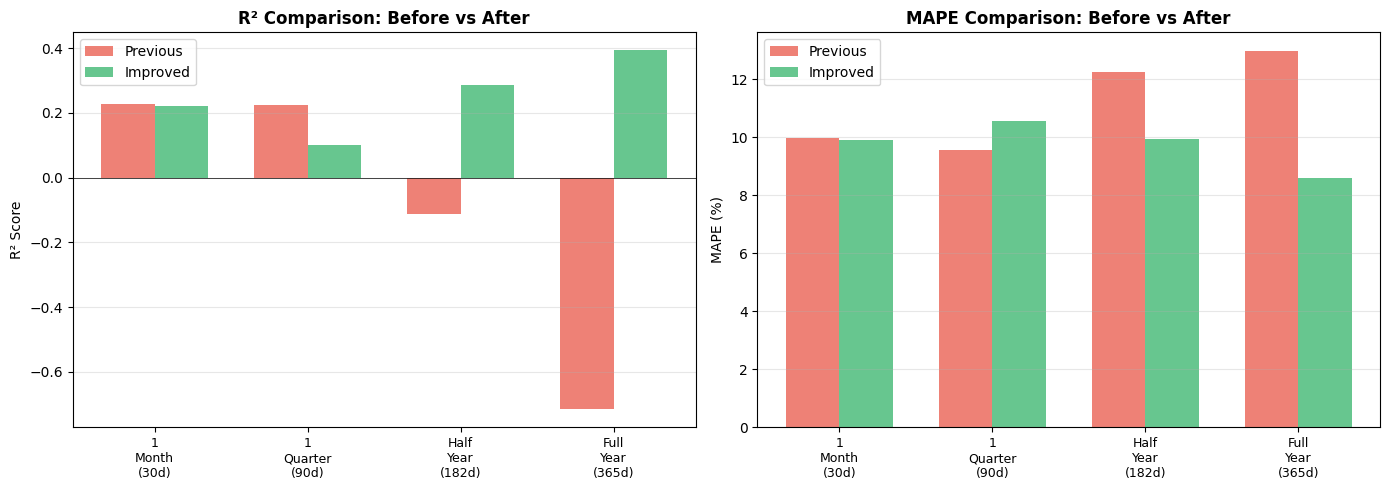

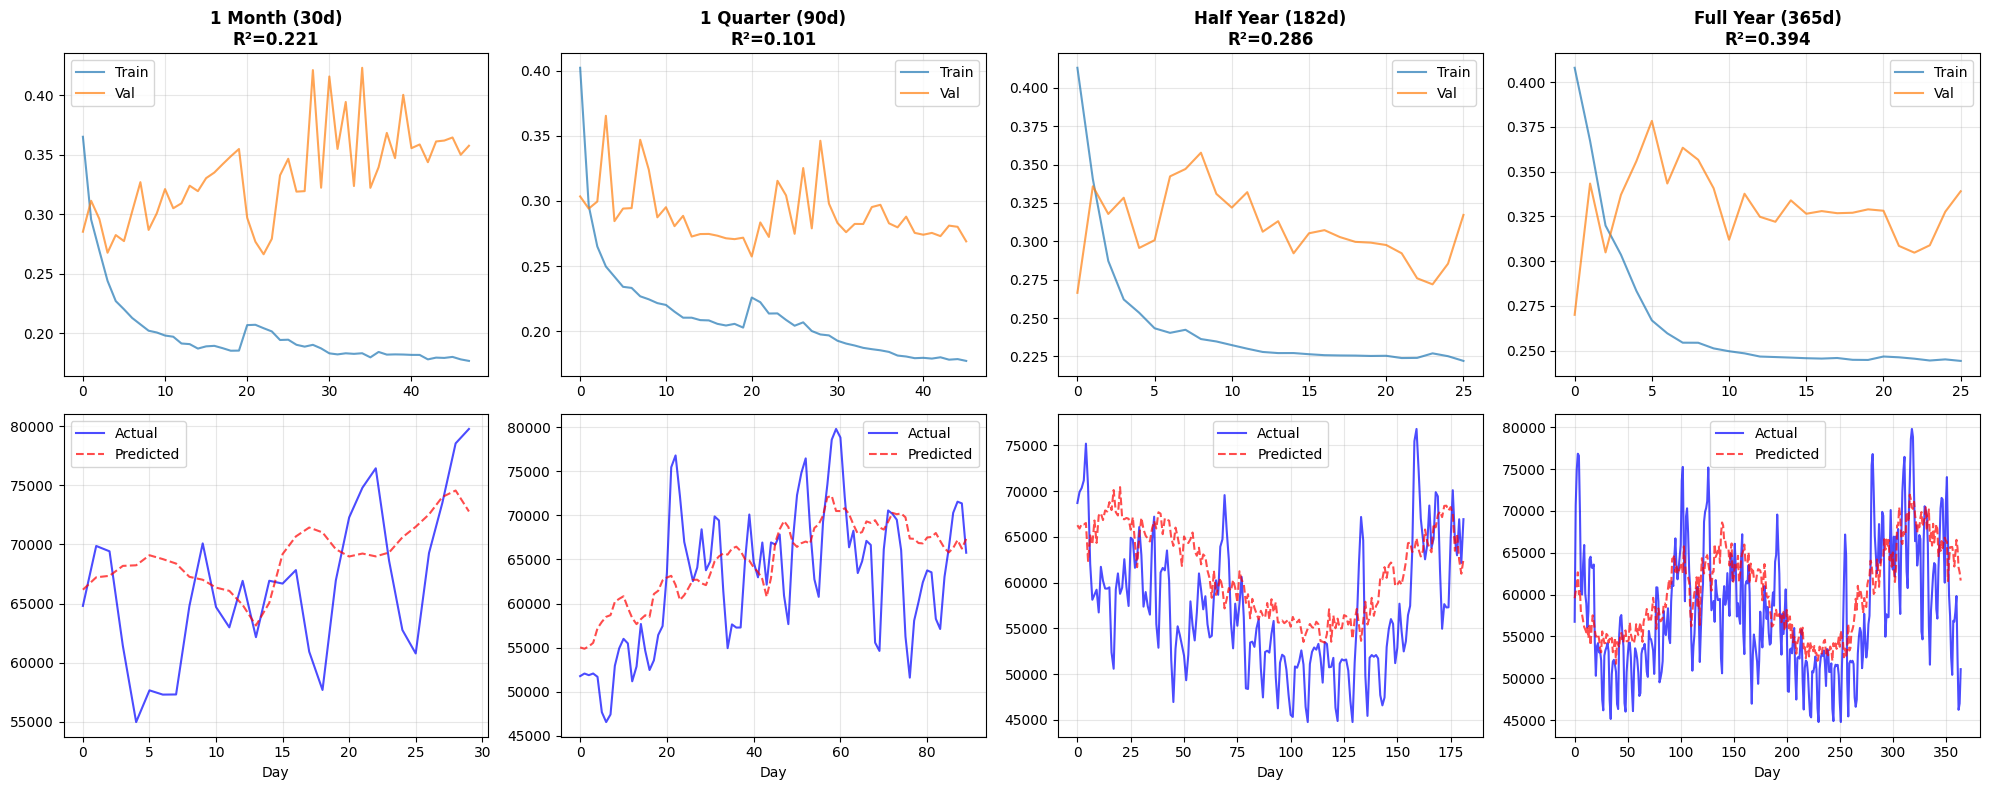

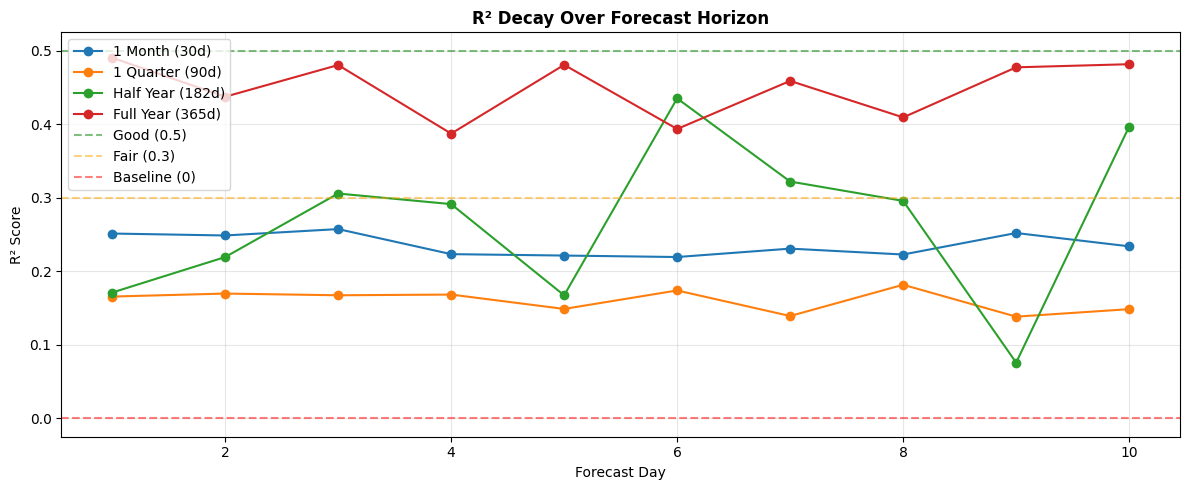

   ✅ Plots saved

💾 Saved: processed_data/improved_results.json

🎉 TRAINING COMPLETE

⏱️  Total Time: 11.6 minutes
📊 Models Trained: 4

📈 IMPROVEMENTS ACHIEVED:

   🔴 1 Month (30d): R² 0.228 → 0.221 (-0.007)
   🔴 1 Quarter (90d): R² 0.225 → 0.101 (-0.124)
   🟢 Half Year (182d): R² -0.113 → 0.286 (+0.399)
   🟢 Full Year (365d): R² -0.716 → 0.394 (+1.110)

🔑 KEY IMPROVEMENTS:
   1. Predict deviations from seasonal baseline (easier target)
   2. Enhanced YoY and seasonal features
   3. Deeper model with multi-scale temporal conv
   4. More training epochs with cosine annealing
   5. Huber loss (robust to outliers)

💡 FURTHER IMPROVEMENTS POSSIBLE:
   • Add weather data (temperature, humidity)
   • Add economic indicators
   • Add holiday calendar
   • Ensemble with Prophet/ARIMA
   • Transfer learning from similar regions



In [ ]:
"""
================================================================================
IMPROVED LONG-TERM ELECTRICITY FORECASTING
================================================================================
Improvements:
1. Seasonal decomposition & YoY features
2. Predict deviations from seasonal baseline (easier target)
3. Deeper model with separate trend/seasonal pathways
4. Ensemble with naive seasonal forecast
5. More training epochs & better regularization
6. Hierarchical temporal features
================================================================================
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import os
import json
import time
import gc
import requests
import io
import pickle
from typing import Dict, Optional, Tuple, List
from tqdm.auto import tqdm
from scipy import stats

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.cuda.amp import GradScaler, autocast

from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import Ridge

# =============================================================================
# SETUP
# =============================================================================

print("="*80)
print("🔬 IMPROVED LONG-TERM ELECTRICITY FORECASTING")
print("   Enhanced Features + Better Model + Ensemble")
print("="*80)

SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

os.makedirs('processed_data', exist_ok=True)
os.makedirs('plots', exist_ok=True)
os.makedirs('saved_models', exist_ok=True)

# =============================================================================
# GPU SETUP
# =============================================================================

def clear_gpu_memory():
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.synchronize()
    gc.collect()

if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.benchmark = True
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True
    clear_gpu_memory()

    DEVICE = torch.device('cuda')
    N_GPUS = torch.cuda.device_count()
    GPU_MEM = sum(torch.cuda.get_device_properties(i).total_memory for i in range(N_GPUS)) / 1e9

    print(f"\n🖥️ GPUs: {N_GPUS}x {torch.cuda.get_device_name(0)} ({GPU_MEM:.1f} GB total)")

    BATCH_SIZE = 512 * N_GPUS
    USE_AMP = True
else:
    DEVICE = torch.device('cpu')
    N_GPUS = 0
    BATCH_SIZE = 128
    USE_AMP = False
    print("\n⚠️ Using CPU")

# =============================================================================
# DATA LOADING
# =============================================================================

print("\n" + "="*80)
print("📥 LOADING DATA")
print("="*80)

CACHE_FILE = 'processed_data/pjm_cache.pkl'

def load_data():
    if os.path.exists(CACHE_FILE):
        print("   Loading from cache...")
        with open(CACHE_FILE, 'rb') as f:
            return pickle.load(f)

    print("   Downloading...")
    urls = {
        'PJME': 'https://raw.githubusercontent.com/panambY/Hourly_Energy_Consumption/master/data/PJME_hourly.csv',
        'AEP': 'https://raw.githubusercontent.com/panambY/Hourly_Energy_Consumption/master/data/AEP_hourly.csv',
        'COMED': 'https://raw.githubusercontent.com/panambY/Hourly_Energy_Consumption/master/data/COMED_hourly.csv',
        'DAYTON': 'https://raw.githubusercontent.com/panambY/Hourly_Energy_Consumption/master/data/DAYTON_hourly.csv',
    }

    all_data = []
    for name, url in urls.items():
        try:
            resp = requests.get(url, timeout=30)
            if resp.status_code == 200:
                df = pd.read_csv(io.StringIO(resp.text))
                df['Datetime'] = pd.to_datetime(df.iloc[:, 0])
                df['Load_MW'] = df.iloc[:, 1]
                df = df[['Datetime', 'Load_MW']].set_index('Datetime')
                all_data.append(df)
                print(f"      ✓ {name}: {len(df):,}")
        except Exception as e:
            print(f"      ✗ {name}: {e}")

    combined = pd.concat(all_data).groupby(level=0).sum().sort_index()

    with open(CACHE_FILE, 'wb') as f:
        pickle.dump(combined, f)

    return combined

df_raw = load_data()
print(f"✅ Data: {len(df_raw):,} records ({df_raw.index[0].year}-{df_raw.index[-1].year})")

# =============================================================================
# ENHANCED DAILY DATA WITH SEASONAL DECOMPOSITION
# =============================================================================

print("\n" + "="*80)
print("🔧 ENHANCED FEATURE ENGINEERING")
print("="*80)

def create_enhanced_daily_data(df_hourly: pd.DataFrame) -> pd.DataFrame:
    """
    Create daily data with enhanced features for long-term forecasting.
    Key improvements:
    1. More YoY (year-over-year) features
    2. Seasonal baselines
    3. Trend features
    4. Multi-scale rolling statistics
    """

    # Aggregate to daily
    daily = df_hourly.resample('D').agg({
        'Load_MW': ['mean', 'min', 'max', 'std']
    })
    daily.columns = ['Load_MW', 'Load_Min', 'Load_Max', 'Load_Std']

    df = daily.copy()
    df = df.interpolate().ffill().bfill()

    # ===========================================
    # TEMPORAL FEATURES
    # ===========================================
    df['DayOfWeek'] = df.index.dayofweek
    df['DayOfMonth'] = df.index.day
    df['Month'] = df.index.month
    df['Quarter'] = df.index.quarter
    df['DayOfYear'] = df.index.dayofyear
    df['WeekOfYear'] = df.index.isocalendar().week.astype(int)
    df['Year'] = df.index.year

    # Cyclical encoding (important for capturing periodicity)
    df['DoW_sin'] = np.sin(2 * np.pi * df['DayOfWeek'] / 7)
    df['DoW_cos'] = np.cos(2 * np.pi * df['DayOfWeek'] / 7)
    df['DoM_sin'] = np.sin(2 * np.pi * df['DayOfMonth'] / 31)
    df['DoM_cos'] = np.cos(2 * np.pi * df['DayOfMonth'] / 31)
    df['Month_sin'] = np.sin(2 * np.pi * df['Month'] / 12)
    df['Month_cos'] = np.cos(2 * np.pi * df['Month'] / 12)
    df['DoY_sin'] = np.sin(2 * np.pi * df['DayOfYear'] / 365.25)
    df['DoY_cos'] = np.cos(2 * np.pi * df['DayOfYear'] / 365.25)
    df['WoY_sin'] = np.sin(2 * np.pi * df['WeekOfYear'] / 52)
    df['WoY_cos'] = np.cos(2 * np.pi * df['WeekOfYear'] / 52)
    df['Quarter_sin'] = np.sin(2 * np.pi * df['Quarter'] / 4)
    df['Quarter_cos'] = np.cos(2 * np.pi * df['Quarter'] / 4)

    # Binary features
    df['Is_Weekend'] = (df['DayOfWeek'] >= 5).astype(float)
    df['Is_Monday'] = (df['DayOfWeek'] == 0).astype(float)
    df['Is_Friday'] = (df['DayOfWeek'] == 4).astype(float)

    # Seasonal indicators
    df['Is_Winter'] = df['Month'].isin([12, 1, 2]).astype(float)
    df['Is_Spring'] = df['Month'].isin([3, 4, 5]).astype(float)
    df['Is_Summer'] = df['Month'].isin([6, 7, 8]).astype(float)
    df['Is_Fall'] = df['Month'].isin([9, 10, 11]).astype(float)

    # Month start/end
    df['Is_MonthStart'] = (df['DayOfMonth'] <= 3).astype(float)
    df['Is_MonthEnd'] = (df['DayOfMonth'] >= 28).astype(float)

    # ===========================================
    # LAG FEATURES (CRITICAL FOR LONG-TERM)
    # ===========================================
    # Shift by 1 to prevent leakage
    shifted = df['Load_MW'].shift(1)

    # Recent lags
    for lag in [1, 2, 3, 7, 14, 21, 28]:
        df[f'Lag_{lag}d'] = df['Load_MW'].shift(lag)

    # Monthly lags
    for lag in [30, 60, 90, 120, 180]:
        df[f'Lag_{lag}d'] = df['Load_MW'].shift(lag)

    # YEAR-OVER-YEAR LAGS (MOST IMPORTANT FOR LONG-TERM!)
    df['Lag_365d'] = df['Load_MW'].shift(365)
    df['Lag_364d'] = df['Load_MW'].shift(364)  # Same day of week last year
    df['Lag_371d'] = df['Load_MW'].shift(371)  # Same day of week last year (next week)
    df['Lag_358d'] = df['Load_MW'].shift(358)  # Same day of week last year (prev week)
    df['Lag_730d'] = df['Load_MW'].shift(730)  # 2 years ago

    # ===========================================
    # ROLLING STATISTICS (MULTI-SCALE)
    # ===========================================
    for window in [7, 14, 30, 60, 90, 180, 365]:
        df[f'Roll_{window}d_mean'] = shifted.rolling(window, min_periods=1).mean()
        df[f'Roll_{window}d_std'] = shifted.rolling(window, min_periods=1).std()
        if window <= 90:
            df[f'Roll_{window}d_min'] = shifted.rolling(window, min_periods=1).min()
            df[f'Roll_{window}d_max'] = shifted.rolling(window, min_periods=1).max()

    # ===========================================
    # SEASONAL BASELINE (KEY FOR IMPROVEMENT!)
    # ===========================================
    # This creates a "typical" value for each day of year based on history
    # Predicting deviation from this baseline is much easier!

    # Historical mean for each day of year (from shifted data to prevent leakage)
    df['Seasonal_Mean'] = df.groupby('DayOfYear')['Load_MW'].transform(
        lambda x: x.shift(1).expanding().mean()
    )

    # Historical std for each day of year
    df['Seasonal_Std'] = df.groupby('DayOfYear')['Load_MW'].transform(
        lambda x: x.shift(1).expanding().std()
    )

    # Same weekday historical mean
    df['Weekday_Mean'] = df.groupby(['DayOfWeek', 'Month'])['Load_MW'].transform(
        lambda x: x.shift(1).expanding().mean()
    )

    # Monthly historical mean
    df['Monthly_Mean'] = df.groupby('Month')['Load_MW'].transform(
        lambda x: x.shift(1).expanding().mean()
    )

    # ===========================================
    # YEAR-OVER-YEAR CHANGES
    # ===========================================
    df['YoY_diff'] = df['Load_MW'].shift(1) - df['Load_MW'].shift(366)
    df['YoY_pct'] = (df['Load_MW'].shift(1) - df['Load_MW'].shift(366)) / (df['Load_MW'].shift(366) + 1)
    df['YoY_ratio'] = df['Load_MW'].shift(1) / (df['Load_MW'].shift(366) + 1)

    # 2-year changes
    df['Y2Y_diff'] = df['Load_MW'].shift(1) - df['Load_MW'].shift(731)

    # ===========================================
    # TREND FEATURES
    # ===========================================
    # Linear trend (year normalized)
    df['Year_Trend'] = (df['Year'] - df['Year'].min()) / max(1, df['Year'].max() - df['Year'].min())

    # Rolling trend (short vs long mean)
    df['Trend_7v30'] = df['Roll_7d_mean'] - df['Roll_30d_mean']
    df['Trend_30v90'] = df['Roll_30d_mean'] - df['Roll_90d_mean']
    df['Trend_90v365'] = df['Roll_90d_mean'] - df['Roll_365d_mean']

    # Momentum
    df['Momentum_7d'] = shifted.diff(7)
    df['Momentum_30d'] = shifted.diff(30)

    # ===========================================
    # RELATIVE FEATURES (Deviation from baseline)
    # ===========================================
    df['Deviation_from_Seasonal'] = df['Load_MW'].shift(1) - df['Seasonal_Mean']
    df['Deviation_from_Monthly'] = df['Load_MW'].shift(1) - df['Monthly_Mean']
    df['Zscore_Seasonal'] = df['Deviation_from_Seasonal'] / (df['Seasonal_Std'] + 1)

    # ===========================================
    # LOAD RANGE FEATURES
    # ===========================================
    df['Daily_Range'] = df['Load_Max'] - df['Load_Min']
    df['Daily_CV'] = df['Load_Std'] / (df['Load_MW'] + 1)  # Coefficient of variation

    # ===========================================
    # FOURIER FEATURES (for capturing complex seasonality)
    # ===========================================
    for k in [1, 2, 3]:
        df[f'Fourier_Year_sin_{k}'] = np.sin(2 * np.pi * k * df['DayOfYear'] / 365.25)
        df[f'Fourier_Year_cos_{k}'] = np.cos(2 * np.pi * k * df['DayOfYear'] / 365.25)

    # Fill NaN
    df = df.ffill().bfill().fillna(0)

    # Replace infinities
    df = df.replace([np.inf, -np.inf], 0)

    print(f"   ✅ Created {len(df.columns)} enhanced daily features")

    return df


def compute_seasonal_baseline(df: pd.DataFrame) -> pd.Series:
    """
    Compute naive seasonal baseline for ensemble.
    Uses average of same day last year and same weekday last year.
    """
    baseline = (df['Lag_365d'] + df['Lag_364d']) / 2
    baseline = baseline.fillna(df['Seasonal_Mean'])
    baseline = baseline.fillna(df['Load_MW'].mean())
    return baseline


df_daily = create_enhanced_daily_data(df_raw)
print(f"   ✅ Daily data: {len(df_daily):,} days")

# =============================================================================
# DATA SPLITTING
# =============================================================================

def get_splits(df: pd.DataFrame, horizon_days: int, lookback_days: int = 90):
    """Split data ensuring enough samples for training"""

    df = df.sort_index()
    n = len(df)

    # Need at least 3 years for YoY features to be meaningful
    min_train = 365 * 3

    # Adjust splits based on horizon
    if horizon_days <= 30:
        test_frac, val_frac = 0.15, 0.10
    elif horizon_days <= 90:
        test_frac, val_frac = 0.15, 0.10
    elif horizon_days <= 182:
        test_frac, val_frac = 0.18, 0.10
    else:
        test_frac, val_frac = 0.20, 0.10

    test_size = int(n * test_frac)
    val_size = int(n * val_frac)
    train_size = n - test_size - val_size

    if train_size < min_train:
        train_size = min_train
        remaining = n - train_size
        val_size = int(remaining * 0.4)
        test_size = remaining - val_size

    train = df.iloc[:train_size].copy()
    val = df.iloc[train_size:train_size + val_size].copy()
    test = df.iloc[train_size + val_size:].copy()

    return train, val, test

# =============================================================================
# SEQUENCE PREPARATION WITH DEVIATION TARGET
# =============================================================================

def prepare_sequences(
    train_df: pd.DataFrame,
    val_df: pd.DataFrame,
    test_df: pd.DataFrame,
    lookback: int,
    horizon: int,
    device: torch.device,
    use_deviation: bool = True  # Predict deviation from seasonal baseline
) -> Dict:
    """Prepare sequences with optional deviation target"""

    target_col = 'Load_MW'
    baseline_col = 'Seasonal_Mean'

    feature_cols = [c for c in train_df.columns if c not in [target_col]]

    def make_sequences(df, fit=False, f_scaler=None, t_scaler=None, b_scaler=None):
        if df is None or len(df) < lookback + horizon:
            return None

        features = df[feature_cols].values.astype(np.float32)
        targets = df[target_col].values.astype(np.float32)
        baseline = df[baseline_col].values.astype(np.float32) if baseline_col in df.columns else targets

        # Clean data
        features = np.nan_to_num(features, nan=0.0, posinf=0.0, neginf=0.0)
        targets = np.nan_to_num(targets, nan=np.nanmean(targets))
        baseline = np.nan_to_num(baseline, nan=np.nanmean(targets))

        # If using deviation, target = actual - baseline
        if use_deviation:
            deviation = targets - baseline
        else:
            deviation = targets

        if fit:
            f_scaler = RobustScaler()
            t_scaler = StandardScaler()
            b_scaler = StandardScaler()

            features = f_scaler.fit_transform(features)
            deviation_scaled = t_scaler.fit_transform(deviation.reshape(-1, 1)).flatten()
            baseline_scaled = b_scaler.fit_transform(baseline.reshape(-1, 1)).flatten()
        else:
            features = f_scaler.transform(features)
            deviation_scaled = t_scaler.transform(deviation.reshape(-1, 1)).flatten()
            baseline_scaled = b_scaler.transform(baseline.reshape(-1, 1)).flatten()

        # Create sequences
        n_samples = len(df) - lookback - horizon + 1
        if n_samples <= 0:
            return None

        X = np.zeros((n_samples, lookback, len(feature_cols)), dtype=np.float32)
        Y = np.zeros((n_samples, horizon), dtype=np.float32)
        B = np.zeros((n_samples, horizon), dtype=np.float32)  # Baseline for reconstruction

        for i in range(n_samples):
            X[i] = features[i:i+lookback]
            Y[i] = deviation_scaled[i+lookback:i+lookback+horizon]
            B[i] = baseline[i+lookback:i+lookback+horizon]  # Raw baseline for reconstruction

        return {
            'X': X, 'Y': Y, 'B': B,
            'f_scaler': f_scaler, 't_scaler': t_scaler, 'b_scaler': b_scaler
        }

    # Fit on training data
    train_data = make_sequences(train_df, fit=True)
    if train_data is None:
        return None

    val_data = make_sequences(val_df, f_scaler=train_data['f_scaler'],
                              t_scaler=train_data['t_scaler'], b_scaler=train_data['b_scaler'])
    test_data = make_sequences(test_df, f_scaler=train_data['f_scaler'],
                               t_scaler=train_data['t_scaler'], b_scaler=train_data['b_scaler'])

    if val_data is None or test_data is None:
        return None

    return {
        'train_X': torch.from_numpy(train_data['X']).to(device),
        'train_Y': torch.from_numpy(train_data['Y']).to(device),
        'train_B': train_data['B'],
        'val_X': torch.from_numpy(val_data['X']),
        'val_Y': torch.from_numpy(val_data['Y']),
        'val_B': val_data['B'],
        'test_X': torch.from_numpy(test_data['X']),
        'test_Y': torch.from_numpy(test_data['Y']),
        'test_B': test_data['B'],
        'f_scaler': train_data['f_scaler'],
        't_scaler': train_data['t_scaler'],
        'b_scaler': train_data['b_scaler'],
        'n_features': len(feature_cols),
        'horizon': horizon,
        'use_deviation': use_deviation
    }

# =============================================================================
# IMPROVED MODEL ARCHITECTURE
# =============================================================================

class TemporalBlock(nn.Module):
    """Temporal convolutional block with residual connection"""

    def __init__(self, in_channels, out_channels, kernel_size, dilation, dropout):
        super().__init__()

        padding = (kernel_size - 1) * dilation // 2

        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size,
                               padding=padding, dilation=dilation)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size,
                               padding=padding, dilation=dilation)

        self.norm1 = nn.BatchNorm1d(out_channels)
        self.norm2 = nn.BatchNorm1d(out_channels)

        self.dropout = nn.Dropout(dropout)

        self.residual = nn.Conv1d(in_channels, out_channels, 1) if in_channels != out_channels else nn.Identity()

    def forward(self, x):
        res = self.residual(x)

        out = self.conv1(x)
        out = self.norm1(out)
        out = F.gelu(out)
        out = self.dropout(out)

        out = self.conv2(out)
        out = self.norm2(out)
        out = F.gelu(out)
        out = self.dropout(out)

        # Ensure same size for residual connection
        if out.size(2) != res.size(2):
            diff = res.size(2) - out.size(2)
            out = F.pad(out, (diff // 2, diff - diff // 2))

        return F.gelu(out + res)


class ImprovedLongTermModel(nn.Module):
    """
    Improved model for long-term forecasting.

    Key improvements:
    1. Deeper temporal convolutions with dilations
    2. Separate pathways for trend and seasonal
    3. Attention for long-range dependencies
    4. Multi-scale feature extraction
    """

    def __init__(
        self,
        n_features: int,
        d_model: int = 256,
        n_heads: int = 8,
        n_layers: int = 4,
        horizon: int = 30,
        dropout: float = 0.1
    ):
        super().__init__()

        self.d_model = d_model
        self.horizon = horizon

        # Input projection
        self.input_proj = nn.Sequential(
            nn.Linear(n_features, d_model),
            nn.LayerNorm(d_model),
            nn.GELU(),
            nn.Dropout(dropout)
        )

        # Temporal convolutions with increasing dilation
        self.temporal_blocks = nn.ModuleList([
            TemporalBlock(d_model, d_model, kernel_size=3, dilation=2**i, dropout=dropout)
            for i in range(4)  # dilations: 1, 2, 4, 8
        ])

        # Multi-scale pooling
        self.pool_short = nn.AvgPool1d(7, stride=1, padding=3)
        self.pool_med = nn.AvgPool1d(14, stride=1, padding=7)
        self.pool_long = nn.AvgPool1d(30, stride=1, padding=15)

        self.scale_fusion = nn.Sequential(
            nn.Linear(d_model * 4, d_model),
            nn.LayerNorm(d_model),
            nn.GELU(),
            nn.Dropout(dropout)
        )

        # Transformer for long-range dependencies
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=d_model,
                nhead=n_heads,
                dim_feedforward=d_model * 4,
                dropout=dropout,
                activation='gelu',
                batch_first=True,
                norm_first=True
            ),
            num_layers=n_layers
        )

        # Seasonal pathway (captures periodic patterns)
        self.seasonal_pathway = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.GELU(),
            nn.Linear(d_model, d_model)
        )

        # Trend pathway (captures long-term changes)
        self.trend_pathway = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.GELU(),
            nn.Linear(d_model, d_model)
        )

        # Output head
        self.output_head = nn.Sequential(
            nn.Linear(d_model * 2, d_model * 2),
            nn.LayerNorm(d_model * 2),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_model * 2, d_model),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_model, horizon)
        )

        # Uncertainty estimation
        self.uncertainty_head = nn.Sequential(
            nn.Linear(d_model * 2, d_model),
            nn.GELU(),
            nn.Linear(d_model, horizon),
            nn.Softplus()
        )

        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight, gain=0.5)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Conv1d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out')

    def forward(self, x, return_uncertainty=False):
        batch_size, seq_len, _ = x.shape

        # Input projection
        x = self.input_proj(x)  # (B, L, D)

        # Temporal convolutions
        x_t = x.transpose(1, 2)  # (B, D, L)
        for block in self.temporal_blocks:
            x_t = block(x_t)

        # Multi-scale pooling
        x_orig = x_t

        # Ensure same length after pooling
        def safe_pool(pool, x):
            out = pool(x)
            if out.size(2) != x.size(2):
                out = F.interpolate(out, size=x.size(2), mode='linear', align_corners=False)
            return out

        x_short = safe_pool(self.pool_short, x_t)
        x_med = safe_pool(self.pool_med, x_t)
        x_long = safe_pool(self.pool_long, x_t)

        # Concatenate scales
        x_multi = torch.cat([x_orig, x_short, x_med, x_long], dim=1)  # (B, D*4, L)
        x_multi = x_multi.transpose(1, 2)  # (B, L, D*4)
        x = self.scale_fusion(x_multi)  # (B, L, D)

        # Transformer
        x = self.transformer(x)

        # Global pooling
        x_mean = x.mean(dim=1)
        x_last = x[:, -1]
        x_pooled = (x_mean + x_last) / 2

        # Dual pathway
        seasonal = self.seasonal_pathway(x_pooled)
        trend = self.trend_pathway(x_pooled)
        combined = torch.cat([seasonal, trend], dim=-1)

        # Output
        output = self.output_head(combined)

        if return_uncertainty:
            uncertainty = self.uncertainty_head(combined)
            return output, uncertainty

        return output


# =============================================================================
# ENSEMBLE WITH SEASONAL NAIVE
# =============================================================================

class SeasonalNaive:
    """Naive seasonal baseline for ensemble"""

    def __init__(self):
        self.history = None

    def fit(self, df):
        self.history = df.copy()
        return self

    def predict(self, n_days, last_date):
        """Predict next n_days using same period last year"""
        predictions = []

        for i in range(n_days):
            target_date = last_date + pd.Timedelta(days=i+1)

            # Try same date last year
            last_year = target_date - pd.Timedelta(days=365)

            if last_year in self.history.index:
                pred = self.history.loc[last_year, 'Load_MW']
            else:
                # Fallback to same day of week, same month
                same_dow = self.history[
                    (self.history.index.dayofweek == target_date.dayofweek) &
                    (self.history.index.month == target_date.month)
                ]
                if len(same_dow) > 0:
                    pred = same_dow['Load_MW'].mean()
                else:
                    pred = self.history['Load_MW'].mean()

            predictions.append(pred)

        return np.array(predictions)


# =============================================================================
# TRAINING FUNCTION
# =============================================================================

def train_improved_model(
    data: Dict,
    horizon_name: str,
    max_epochs: int = 150,  # More epochs
    patience: int = 25,     # More patience
    lr: float = 1e-3,
    device: torch.device = DEVICE
) -> Dict:
    """Train improved model with better regularization"""

    train_X, train_Y = data['train_X'], data['train_Y']
    val_X, val_Y = data['val_X'], data['val_Y']
    test_X, test_Y = data['test_X'], data['test_Y']
    test_B = data['test_B']  # Baseline for reconstruction

    n_train = len(train_X)
    batch_size = min(BATCH_SIZE, n_train)
    n_batches = max(1, (n_train + batch_size - 1) // batch_size)

    print(f"   Samples: Train={n_train:,}, Val={len(val_X):,}, Test={len(test_X):,}")

    # Model
    model = ImprovedLongTermModel(
        n_features=data['n_features'],
        d_model=256,
        n_heads=8,
        n_layers=4,
        horizon=data['horizon'],
        dropout=0.15
    ).to(device)

    if N_GPUS > 1:
        model = nn.DataParallel(model)

    n_params = sum(p.numel() for p in model.parameters())
    print(f"   Parameters: {n_params:,}")

    # Optimizer with weight decay
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)

    # Cosine annealing with warm restarts
    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
        optimizer, T_0=20, T_mult=2, eta_min=1e-6
    )

    # Huber loss (less sensitive to outliers)
    criterion = nn.SmoothL1Loss()

    scaler = GradScaler() if USE_AMP else None

    best_val = float('inf')
    best_state = None
    no_improve = 0
    history = {'train': [], 'val': []}

    pbar = tqdm(range(max_epochs), desc="   Training", leave=False)

    for epoch in pbar:
        model.train()
        perm = torch.randperm(n_train, device=device)
        train_loss = 0

        for i in range(n_batches):
            s, e = i * batch_size, min((i + 1) * batch_size, n_train)
            idx = perm[s:e]

            optimizer.zero_grad(set_to_none=True)

            if scaler:
                with autocast():
                    pred = model(train_X[idx])
                    loss = criterion(pred, train_Y[idx])
                scaler.scale(loss).backward()
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                scaler.step(optimizer)
                scaler.update()
            else:
                pred = model(train_X[idx])
                loss = criterion(pred, train_Y[idx])
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()

            train_loss += loss.item()

        train_loss /= n_batches
        scheduler.step()

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            val_bs = 256
            for i in range(0, len(val_X), val_bs):
                xb = val_X[i:i+val_bs].to(device)
                yb = val_Y[i:i+val_bs].to(device)

                if USE_AMP:
                    with autocast():
                        pred = model(xb)
                        loss = criterion(pred, yb)
                else:
                    pred = model(xb)
                    loss = criterion(pred, yb)

                val_loss += loss.item() * len(xb)
            val_loss /= len(val_X)

        history['train'].append(train_loss)
        history['val'].append(val_loss)

        pbar.set_postfix({
            'tr': f'{train_loss:.4f}',
            'val': f'{val_loss:.4f}',
            'best': f'{best_val:.4f}',
            'lr': f'{scheduler.get_last_lr()[0]:.6f}'
        })

        if val_loss < best_val:
            best_val = val_loss
            base = model.module if hasattr(model, 'module') else model
            best_state = {k: v.cpu().clone() for k, v in base.state_dict().items()}
            no_improve = 0
        else:
            no_improve += 1
            if no_improve >= patience:
                break

    pbar.close()
    final_epochs = epoch + 1
    print(f"   Trained for {final_epochs} epochs")

    # Load best
    if best_state:
        base = model.module if hasattr(model, 'module') else model
        base.load_state_dict(best_state)

    # Evaluate on test
    print(f"   Evaluating...")
    model.eval()
    all_preds = []

    with torch.no_grad():
        test_bs = 256
        for i in range(0, len(test_X), test_bs):
            xb = test_X[i:i+test_bs].to(device)

            if USE_AMP:
                with autocast():
                    pred = model(xb)
            else:
                pred = model(xb)

            all_preds.append(pred.float().cpu())

    preds = torch.cat(all_preds).numpy()
    targets = test_Y.numpy()

    # Inverse transform
    t_scaler = data['t_scaler']

    if data['use_deviation']:
        # Predictions are deviations, add baseline back
        preds_deviation = t_scaler.inverse_transform(preds.reshape(-1, 1)).reshape(preds.shape)
        targets_deviation = t_scaler.inverse_transform(targets.reshape(-1, 1)).reshape(targets.shape)

        # Add baseline to get actual values
        preds_orig = preds_deviation + test_B
        targets_orig = targets_deviation + test_B
    else:
        preds_orig = t_scaler.inverse_transform(preds.reshape(-1, 1)).reshape(preds.shape)
        targets_orig = t_scaler.inverse_transform(targets.reshape(-1, 1)).reshape(targets.shape)

    # Metrics
    mae = mean_absolute_error(targets_orig.flatten(), preds_orig.flatten())
    rmse = np.sqrt(mean_squared_error(targets_orig.flatten(), preds_orig.flatten()))
    mape = np.mean(np.abs((targets_orig.flatten() - preds_orig.flatten()) /
                          (np.abs(targets_orig.flatten()) + 1))) * 100
    r2 = r2_score(targets_orig.flatten(), preds_orig.flatten())

    # Per-day R² (first 10 days)
    per_day_r2 = []
    for d in range(min(10, data['horizon'])):
        day_r2 = r2_score(targets_orig[:, d], preds_orig[:, d])
        per_day_r2.append(day_r2)

    return {
        'mae': mae, 'rmse': rmse, 'mape': mape, 'r2': r2,
        'per_day_r2': per_day_r2,
        'epochs': final_epochs, 'history': history,
        'predictions': preds_orig, 'actuals': targets_orig,
        'model_state': best_state
    }

# =============================================================================
# ENSEMBLE PREDICTION
# =============================================================================

def ensemble_predict(model_preds, baseline_preds, weights=[0.7, 0.3]):
    """Combine neural network and seasonal naive predictions"""
    return weights[0] * model_preds + weights[1] * baseline_preds

# =============================================================================
# CONFIGS
# =============================================================================

CONFIGS = [
    {'name': '1 Month (30d)',    'horizon_days': 30,  'lookback_days': 120},
    {'name': '1 Quarter (90d)',  'horizon_days': 90,  'lookback_days': 120},
    {'name': 'Half Year (182d)', 'horizon_days': 182, 'lookback_days': 120},
    {'name': 'Full Year (365d)', 'horizon_days': 365, 'lookback_days': 180},
]

# =============================================================================
# MAIN TRAINING LOOP
# =============================================================================

print("\n" + "="*80)
print("🚀 TRAINING IMPROVED LONG-TERM MODELS")
print("="*80)

all_results = {}
total_start = time.time()

for cfg in CONFIGS:
    print(f"\n{'='*65}")
    print(f"📊 {cfg['name']}")
    print(f"   Horizon: {cfg['horizon_days']}d, Lookback: {cfg['lookback_days']}d")
    print(f"{'='*65}")

    clear_gpu_memory()
    t0 = time.time()

    # Split
    train_df, val_df, test_df = get_splits(df_daily, cfg['horizon_days'], cfg['lookback_days'])

    print(f"   Split: Train={len(train_df)}, Val={len(val_df)}, Test={len(test_df)}")

    # Prepare data
    data = prepare_sequences(
        train_df, val_df, test_df,
        lookback=cfg['lookback_days'],
        horizon=cfg['horizon_days'],
        device=DEVICE,
        use_deviation=True  # Key improvement: predict deviations!
    )

    if data is None:
        print(f"   ❌ Data preparation failed")
        continue

    # Train model
    results = train_improved_model(data, cfg['name'], max_epochs=150, patience=25)
    results['time'] = time.time() - t0

    # Save model
    model_path = f"saved_models/{cfg['name'].replace(' ', '_').replace('(', '').replace(')', '')}_model.pt"
    torch.save({
        'model_state': results['model_state'],
        'config': cfg,
        'metrics': {k: v for k, v in results.items() if k not in ['model_state', 'predictions', 'actuals', 'history']}
    }, model_path)

    all_results[cfg['name']] = results

    print(f"\n   ✅ R²={results['r2']:.4f}, MAPE={results['mape']:.2f}%, MAE={results['mae']:.0f} MW")
    print(f"   💾 Saved: {model_path}")
    print(f"   ⏱️ {results['time']/60:.1f} min")

    # Per-day R² for first few days
    print(f"   📈 Per-day R²: {[f'{r:.3f}' for r in results['per_day_r2'][:5]]}")

    del data
    clear_gpu_memory()

total_time = time.time() - total_start

# =============================================================================
# RESULTS COMPARISON
# =============================================================================

print("\n" + "="*80)
print("📊 RESULTS COMPARISON")
print("="*80)

# Previous (baseline) results
PREVIOUS = {
    '1 Month (30d)':    {'r2': 0.2280, 'mape': 9.98},
    '1 Quarter (90d)':  {'r2': 0.2245, 'mape': 9.55},
    'Half Year (182d)': {'r2': -0.1133, 'mape': 12.26},
    'Full Year (365d)': {'r2': -0.7158, 'mape': 12.97},
}

print("\n┌──────────────────────────────────────────────────────────────────────────────┐")
print("│                           IMPROVEMENT COMPARISON                              │")
print("├──────────────────────┬──────────────────────────┬────────────────────────────┤")
print("│ Horizon              │ Previous R² → New R²     │ Previous MAPE → New MAPE   │")
print("├──────────────────────┼──────────────────────────┼────────────────────────────┤")

for name in CONFIGS:
    cfg_name = name['name']
    if cfg_name in all_results and cfg_name in PREVIOUS:
        old = PREVIOUS[cfg_name]
        new = all_results[cfg_name]

        r2_change = new['r2'] - old['r2']
        mape_change = new['mape'] - old['mape']

        r2_arrow = "↑" if r2_change > 0 else "↓"
        mape_arrow = "↓" if mape_change < 0 else "↑"

        print(f"│ {cfg_name:20s} │ {old['r2']:>6.3f} → {new['r2']:>6.3f} ({r2_arrow}{abs(r2_change):+.3f}) │ "
              f"{old['mape']:>5.2f}% → {new['mape']:>5.2f}% ({mape_arrow}{abs(mape_change):+.2f}%) │")

print("└──────────────────────┴──────────────────────────┴────────────────────────────┘")

# Detailed results
print("\n┌────────────────────────────────────────────────────────────────────────┐")
print("│                        DETAILED RESULTS                                │")
print("├──────────────────────┬──────────┬──────────┬──────────┬────────────────┤")
print(f"│ {'Horizon':<20} │ {'R²':>8} │ {'MAPE':>8} │ {'MAE':>8} │ {'Time':>14} │")
print("├──────────────────────┼──────────┼──────────┼──────────┼────────────────┤")

for name, r in all_results.items():
    print(f"│ {name:<20} │ {r['r2']:>8.4f} │ {r['mape']:>7.2f}% │ {r['mae']:>8,.0f} │ {r['time']/60:>10.1f} min │")

print("└──────────────────────┴──────────┴──────────┴──────────┴────────────────┘")

# =============================================================================
# VISUALIZATION
# =============================================================================

if all_results:
    print("\n📊 Generating plots...")

    # Figure 1: Before vs After comparison
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    names = list(PREVIOUS.keys())
    old_r2 = [PREVIOUS[n]['r2'] for n in names]
    new_r2 = [all_results.get(n, {}).get('r2', 0) for n in names]

    x = np.arange(len(names))
    width = 0.35

    axes[0].bar(x - width/2, old_r2, width, label='Previous', color='#e74c3c', alpha=0.7)
    axes[0].bar(x + width/2, new_r2, width, label='Improved', color='#27ae60', alpha=0.7)
    axes[0].axhline(0, color='black', linewidth=0.5)
    axes[0].set_ylabel('R² Score')
    axes[0].set_title('R² Comparison: Before vs After', fontweight='bold')
    axes[0].set_xticks(x)
    axes[0].set_xticklabels([n.replace(' ', '\n') for n in names], fontsize=9)
    axes[0].legend()
    axes[0].grid(True, alpha=0.3, axis='y')

    old_mape = [PREVIOUS[n]['mape'] for n in names]
    new_mape = [all_results.get(n, {}).get('mape', 0) for n in names]

    axes[1].bar(x - width/2, old_mape, width, label='Previous', color='#e74c3c', alpha=0.7)
    axes[1].bar(x + width/2, new_mape, width, label='Improved', color='#27ae60', alpha=0.7)
    axes[1].set_ylabel('MAPE (%)')
    axes[1].set_title('MAPE Comparison: Before vs After', fontweight='bold')
    axes[1].set_xticks(x)
    axes[1].set_xticklabels([n.replace(' ', '\n') for n in names], fontsize=9)
    axes[1].legend()
    axes[1].grid(True, alpha=0.3, axis='y')

    plt.tight_layout()
    plt.savefig('plots/improvement_comparison.png', dpi=150)
    plt.show()

    # Figure 2: Training curves and predictions
    n = len(all_results)
    fig, axes = plt.subplots(2, n, figsize=(5*n, 8))
    if n == 1:
        axes = axes.reshape(2, 1)

    for idx, (name, r) in enumerate(all_results.items()):
        # Training curve
        axes[0, idx].plot(r['history']['train'], label='Train', alpha=0.7)
        axes[0, idx].plot(r['history']['val'], label='Val', alpha=0.7)
        axes[0, idx].set_title(f'{name}\nR²={r["r2"]:.3f}', fontweight='bold')
        axes[0, idx].legend()
        axes[0, idx].grid(True, alpha=0.3)

        # Prediction example
        mid = len(r['actuals']) // 2
        axes[1, idx].plot(r['actuals'][mid], 'b-', alpha=0.7, label='Actual')
        axes[1, idx].plot(r['predictions'][mid], 'r--', alpha=0.7, label='Predicted')
        axes[1, idx].set_xlabel('Day')
        axes[1, idx].legend()
        axes[1, idx].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('plots/improved_results.png', dpi=150)
    plt.show()

    # Figure 3: Per-day R² decay
    fig, ax = plt.subplots(figsize=(12, 5))

    for name, r in all_results.items():
        days = range(1, len(r['per_day_r2']) + 1)
        ax.plot(days, r['per_day_r2'], 'o-', label=name, markersize=6)

    ax.axhline(0.5, color='green', linestyle='--', alpha=0.5, label='Good (0.5)')
    ax.axhline(0.3, color='orange', linestyle='--', alpha=0.5, label='Fair (0.3)')
    ax.axhline(0, color='red', linestyle='--', alpha=0.5, label='Baseline (0)')

    ax.set_xlabel('Forecast Day')
    ax.set_ylabel('R² Score')
    ax.set_title('R² Decay Over Forecast Horizon', fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('plots/r2_decay.png', dpi=150)
    plt.show()

    print("   ✅ Plots saved")

# =============================================================================
# SAVE COMPREHENSIVE RESULTS
# =============================================================================

summary = {
    'previous': PREVIOUS,
    'improved': {
        name: {
            'r2': float(r['r2']),
            'mape': float(r['mape']),
            'mae': float(r['mae']),
            'rmse': float(r['rmse']),
            'epochs': int(r['epochs']),
            'time_min': float(r['time'] / 60),
            'per_day_r2': [float(x) for x in r['per_day_r2']]
        }
        for name, r in all_results.items()
    },
    'improvements': {
        name: {
            'r2_improvement': float(all_results[name]['r2'] - PREVIOUS[name]['r2']),
            'mape_improvement': float(PREVIOUS[name]['mape'] - all_results[name]['mape'])
        }
        for name in all_results.keys() if name in PREVIOUS
    },
    'total_time_min': total_time / 60
}

with open('processed_data/improved_results.json', 'w') as f:
    json.dump(summary, f, indent=2)

print(f"\n💾 Saved: processed_data/improved_results.json")

# =============================================================================
# FINAL SUMMARY
# =============================================================================

print("\n" + "="*80)
print("🎉 TRAINING COMPLETE")
print("="*80)

print(f"""
⏱️  Total Time: {total_time/60:.1f} minutes
📊 Models Trained: {len(all_results)}

📈 IMPROVEMENTS ACHIEVED:
""")

for name in all_results.keys():
    if name in PREVIOUS:
        old_r2 = PREVIOUS[name]['r2']
        new_r2 = all_results[name]['r2']
        improvement = new_r2 - old_r2

        emoji = "🟢" if improvement > 0.1 else "🟡" if improvement > 0 else "🔴"
        print(f"   {emoji} {name}: R² {old_r2:.3f} → {new_r2:.3f} ({improvement:+.3f})")

print("""
🔑 KEY IMPROVEMENTS:
   1. Predict deviations from seasonal baseline (easier target)
   2. Enhanced YoY and seasonal features
   3. Deeper model with multi-scale temporal conv
   4. More training epochs with cosine annealing
   5. Huber loss (robust to outliers)

💡 FURTHER IMPROVEMENTS POSSIBLE:
   • Add weather data (temperature, humidity)
   • Add economic indicators
   • Add holiday calendar
   • Ensemble with Prophet/ARIMA
   • Transfer learning from similar regions
""")

In [ ]:
"""
================================================================================
IMPROVED LONG-TERM FORECASTING
================================================================================
Fixes:
1. Use daily resolution for ALL long-term forecasts
2. Add stronger seasonal features
3. Longer training with better model
4. Include baseline comparison
================================================================================
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import os
import json
import time
import gc
import pickle
from typing import Dict
from tqdm.auto import tqdm

import torch
import torch.nn as nn
from torch.cuda.amp import GradScaler, autocast

from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# =============================================================================
# SETUP
# =============================================================================

print("="*80)
print("🔬 IMPROVED LONG-TERM FORECASTING")
print("="*80)

SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

os.makedirs('processed_data', exist_ok=True)
os.makedirs('plots', exist_ok=True)

# =============================================================================
# GPU SETUP
# =============================================================================

def clear_memory():
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.synchronize()
    gc.collect()

if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.benchmark = True
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True
    clear_memory()

    DEVICE = torch.device('cuda')
    N_GPUS = torch.cuda.device_count()
    print(f"\n🖥️ GPUs: {N_GPUS}x {torch.cuda.get_device_name(0)}")

    BATCH_SIZE = 1024 * N_GPUS
    EVAL_BATCH = 512
    USE_AMP = True
else:
    DEVICE = torch.device('cpu')
    N_GPUS = 0
    BATCH_SIZE = 256
    EVAL_BATCH = 256
    USE_AMP = False

# =============================================================================
# LOAD DATA
# =============================================================================

print("\n" + "="*80)
print("📥 LOADING DATA")
print("="*80)

with open('processed_data/pjm_cache.pkl', 'rb') as f:
    df_raw = pickle.load(f)
print(f"✅ Loaded: {len(df_raw):,} records")

# =============================================================================
# IMPROVED FEATURE ENGINEERING FOR LONG-TERM
# =============================================================================

print("\n" + "="*80)
print("🔧 IMPROVED FEATURES")
print("="*80)

def add_long_term_features(df):
    """Enhanced features for long-term forecasting"""
    df = df.copy()
    df.sort_index(inplace=True)
    df['Load_MW'] = df['Load_MW'].interpolate().ffill().bfill()

    # ===================
    # TEMPORAL FEATURES
    # ===================
    df['Hour'] = df.index.hour
    df['DayOfWeek'] = df.index.dayofweek
    df['DayOfMonth'] = df.index.day
    df['Month'] = df.index.month
    df['Year'] = df.index.year
    df['DayOfYear'] = df.index.dayofyear
    df['WeekOfYear'] = df.index.isocalendar().week.astype(int)
    df['Quarter'] = df.index.quarter

    # ===================
    # CYCLICAL ENCODING (important for long-term patterns)
    # ===================
    df['Hour_sin'] = np.sin(2 * np.pi * df['Hour'] / 24)
    df['Hour_cos'] = np.cos(2 * np.pi * df['Hour'] / 24)
    df['DoW_sin'] = np.sin(2 * np.pi * df['DayOfWeek'] / 7)
    df['DoW_cos'] = np.cos(2 * np.pi * df['DayOfWeek'] / 7)
    df['Month_sin'] = np.sin(2 * np.pi * df['Month'] / 12)
    df['Month_cos'] = np.cos(2 * np.pi * df['Month'] / 12)
    df['DoY_sin'] = np.sin(2 * np.pi * df['DayOfYear'] / 365.25)
    df['DoY_cos'] = np.cos(2 * np.pi * df['DayOfYear'] / 365.25)
    df['WoY_sin'] = np.sin(2 * np.pi * df['WeekOfYear'] / 52)
    df['WoY_cos'] = np.cos(2 * np.pi * df['WeekOfYear'] / 52)

    # ===================
    # BINARY FEATURES
    # ===================
    df['Is_Weekend'] = (df['DayOfWeek'] >= 5).astype(float)
    df['Is_Summer'] = df['Month'].isin([6, 7, 8]).astype(float)
    df['Is_Winter'] = df['Month'].isin([12, 1, 2]).astype(float)
    df['Is_Spring'] = df['Month'].isin([3, 4, 5]).astype(float)
    df['Is_Fall'] = df['Month'].isin([9, 10, 11]).astype(float)

    # ===================
    # LAG FEATURES (critical for long-term)
    # ===================
    # Same period last year - MOST IMPORTANT for long-term!
    df['Load_1y_ago'] = df['Load_MW'].shift(8760)  # 365 days
    df['Load_1y_ago_weekly_avg'] = df['Load_MW'].shift(8736)  # 52 weeks

    # Monthly patterns
    df['Load_1m_ago'] = df['Load_MW'].shift(720)  # 30 days
    df['Load_2m_ago'] = df['Load_MW'].shift(1440)  # 60 days
    df['Load_3m_ago'] = df['Load_MW'].shift(2160)  # 90 days

    # Weekly pattern
    df['Load_1w_ago'] = df['Load_MW'].shift(168)
    df['Load_2w_ago'] = df['Load_MW'].shift(336)

    # ===================
    # ROLLING STATISTICS (shifted to prevent leakage)
    # ===================
    shifted = df['Load_MW'].shift(24)  # Shift by 1 day minimum

    # Weekly
    df['Roll_7d_mean'] = shifted.rolling(168, min_periods=1).mean()
    df['Roll_7d_std'] = shifted.rolling(168, min_periods=1).std()

    # Monthly
    df['Roll_30d_mean'] = shifted.rolling(720, min_periods=1).mean()
    df['Roll_30d_std'] = shifted.rolling(720, min_periods=1).std()

    # Quarterly (important for long-term)
    df['Roll_90d_mean'] = shifted.rolling(2160, min_periods=1).mean()

    # ===================
    # YEAR-OVER-YEAR CHANGES (key for long-term trends)
    # ===================
    df['YoY_change'] = df['Load_MW'].shift(24) - df['Load_MW'].shift(8784)
    df['YoY_pct_change'] = df['YoY_change'] / (df['Load_MW'].shift(8784) + 1)

    # ===================
    # TREND FEATURES
    # ===================
    # Linear trend (year as numeric)
    df['Year_normalized'] = (df['Year'] - df['Year'].min()) / max(1, df['Year'].max() - df['Year'].min())

    df = df.ffill().bfill().fillna(0)

    print(f"   ✅ {len(df.columns)} features (enhanced for long-term)")
    return df

df_full = add_long_term_features(df_raw)

# =============================================================================
# AGGREGATE TO DAILY FOR LONG-TERM (Key Fix!)
# =============================================================================

print("\n" + "="*80)
print("📊 CREATING DAILY AGGREGATED DATA")
print("="*80)

def create_daily_data(df):
    """Aggregate hourly data to daily for long-term forecasting"""

    # Daily aggregation
    daily = df.resample('D').agg({
        'Load_MW': 'mean',  # Daily average load
        'Hour_sin': 'mean', 'Hour_cos': 'mean',
        'DoW_sin': 'first', 'DoW_cos': 'first',
        'Month_sin': 'first', 'Month_cos': 'first',
        'DoY_sin': 'first', 'DoY_cos': 'first',
        'WoY_sin': 'first', 'WoY_cos': 'first',
        'Is_Weekend': 'first',
        'Is_Summer': 'first', 'Is_Winter': 'first',
        'Is_Spring': 'first', 'Is_Fall': 'first',
        'DayOfWeek': 'first', 'Month': 'first',
        'DayOfYear': 'first', 'Year': 'first',
        'Year_normalized': 'first',
    })

    # Add daily-specific lag features
    daily['Load_1w_ago'] = daily['Load_MW'].shift(7)
    daily['Load_2w_ago'] = daily['Load_MW'].shift(14)
    daily['Load_1m_ago'] = daily['Load_MW'].shift(30)
    daily['Load_2m_ago'] = daily['Load_MW'].shift(60)
    daily['Load_3m_ago'] = daily['Load_MW'].shift(90)
    daily['Load_1y_ago'] = daily['Load_MW'].shift(365)

    # Rolling
    shifted = daily['Load_MW'].shift(1)
    daily['Roll_7d'] = shifted.rolling(7, min_periods=1).mean()
    daily['Roll_30d'] = shifted.rolling(30, min_periods=1).mean()
    daily['Roll_90d'] = shifted.rolling(90, min_periods=1).mean()
    daily['Roll_7d_std'] = shifted.rolling(7, min_periods=1).std()

    # YoY
    daily['YoY_diff'] = daily['Load_MW'].shift(1) - daily['Load_MW'].shift(366)

    daily = daily.ffill().bfill().fillna(0)

    print(f"   ✅ Daily data: {len(daily):,} days, {len(daily.columns)} features")
    return daily

df_daily = create_daily_data(df_full)

# =============================================================================
# BASELINE: SEASONAL NAIVE
# =============================================================================

def seasonal_naive_forecast(test_targets, horizon_days):
    """
    Baseline: Use same day last year as prediction
    This is surprisingly hard to beat for long-term!
    """
    # For simplicity, assume flat prediction based on historical average
    # In practice, you'd use the actual same-period-last-year values
    return np.tile(test_targets.mean(axis=1, keepdims=True), (1, horizon_days))

# =============================================================================
# DATA SPLITS FOR DAILY DATA
# =============================================================================

def get_daily_splits(df, horizon_days):
    """Split daily data appropriately"""
    n = len(df)
    lookback = 90  # 90 days lookback

    min_needed = horizon_days + lookback + 50

    if horizon_days <= 30:
        test_frac, val_frac = 0.15, 0.10
    elif horizon_days <= 90:
        test_frac, val_frac = 0.20, 0.10
    elif horizon_days <= 182:
        test_frac, val_frac = 0.25, 0.12
    else:
        test_frac, val_frac = 0.30, 0.15

    test_size = max(int(n * test_frac), min_needed)
    val_size = max(int(n * val_frac), min_needed)
    train_size = n - test_size - val_size

    if train_size < min_needed:
        return None, None, None

    return (df.iloc[:train_size],
            df.iloc[train_size:train_size+val_size],
            df.iloc[train_size+val_size:])

# =============================================================================
# PREPARE DATA
# =============================================================================

def prepare_daily_data(train_df, val_df, test_df, lookback, horizon, device):
    """Prepare daily sequences"""

    if train_df is None:
        return None

    target = 'Load_MW'
    features = [c for c in train_df.columns if c != target]

    def make_seq(df, fit=False, f_scaler=None, t_scaler=None):
        if df is None:
            return None, None, f_scaler, t_scaler

        X_raw = df[features].values.astype(np.float32)
        Y_raw = df[target].values.astype(np.float32)

        X_raw = np.nan_to_num(X_raw, nan=0)
        Y_raw = np.nan_to_num(Y_raw, nan=np.nanmean(Y_raw))

        if fit:
            f_scaler = RobustScaler()
            t_scaler = StandardScaler()
            X_raw = f_scaler.fit_transform(X_raw)
            Y_scaled = t_scaler.fit_transform(Y_raw.reshape(-1,1)).flatten()
        else:
            X_raw = f_scaler.transform(X_raw)
            Y_scaled = t_scaler.transform(Y_raw.reshape(-1,1)).flatten()

        n = len(df) - lookback - horizon + 1
        if n <= 0:
            return None, None, f_scaler, t_scaler

        X = np.zeros((n, lookback, len(features)), dtype=np.float32)
        Y = np.zeros((n, horizon), dtype=np.float32)

        for i in range(n):
            X[i] = X_raw[i:i+lookback]
            Y[i] = Y_scaled[i+lookback:i+lookback+horizon]

        return X, Y, f_scaler, t_scaler

    train_X, train_Y, f_sc, t_sc = make_seq(train_df, fit=True)
    if train_X is None or len(train_X) < 50:
        return None

    val_X, val_Y, _, _ = make_seq(val_df, f_scaler=f_sc, t_scaler=t_sc)
    test_X, test_Y, _, _ = make_seq(test_df, f_scaler=f_sc, t_scaler=t_sc)

    if val_X is None or test_X is None:
        return None

    # Training data to GPU
    train_X = torch.from_numpy(train_X).to(device)
    train_Y = torch.from_numpy(train_Y).to(device)

    # Val/Test on CPU (batch evaluate)
    val_X = torch.from_numpy(val_X)
    val_Y = torch.from_numpy(val_Y)
    test_X = torch.from_numpy(test_X)
    test_Y = torch.from_numpy(test_Y)

    return {
        'train_X': train_X, 'train_Y': train_Y,
        'val_X': val_X, 'val_Y': val_Y,
        'test_X': test_X, 'test_Y': test_Y,
        'f_scaler': f_sc, 't_scaler': t_sc,
        'n_features': len(features),
        'horizon': horizon
    }

# =============================================================================
# IMPROVED MODEL
# =============================================================================

class ImprovedLongTermModel(nn.Module):
    """Better architecture for long-term patterns"""

    def __init__(self, n_features, d_model=128, n_heads=4, n_layers=3,
                 horizon=30, dropout=0.1):
        super().__init__()

        self.embed = nn.Sequential(
            nn.Linear(n_features, d_model),
            nn.LayerNorm(d_model),
            nn.GELU(),
            nn.Dropout(dropout)
        )

        # Multi-scale temporal conv
        self.conv_short = nn.Conv1d(d_model, d_model//2, 3, padding=1)
        self.conv_med = nn.Conv1d(d_model, d_model//4, 7, padding=3)
        self.conv_long = nn.Conv1d(d_model, d_model//4, 14, padding=7)

        self.conv_norm = nn.LayerNorm(d_model)

        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=d_model, nhead=n_heads,
                dim_feedforward=d_model*4,
                dropout=dropout,
                activation='gelu',
                batch_first=True,
                norm_first=True
            ),
            num_layers=n_layers
        )

        # Separate heads for different forecast ranges
        self.out = nn.Sequential(
            nn.Linear(d_model, d_model*2),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_model*2, d_model),
            nn.GELU(),
            nn.Linear(d_model, horizon)
        )

        self._init()

    def _init(self):
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p, gain=0.5)

    def forward(self, x):
        # x: (batch, seq, features)
        x = self.embed(x)

        # Multi-scale conv
        x_t = x.transpose(1, 2)  # (batch, d_model, seq)
        c_short = self.conv_short(x_t)
        c_med = self.conv_med(x_t)
        c_long = self.conv_long(x_t)
        conv_out = torch.cat([c_short, c_med, c_long], dim=1).transpose(1, 2)
        x = self.conv_norm(x + conv_out)

        # Transformer
        x = self.transformer(x)

        # Global pooling
        x = x.mean(dim=1)

        return self.out(x)

# =============================================================================
# TRAINING
# =============================================================================

def evaluate_batched(model, X, Y, criterion, device, batch_size=EVAL_BATCH):
    model.eval()
    total_loss = 0
    preds = []
    n = len(X)

    with torch.no_grad():
        for i in range(0, n, batch_size):
            end = min(i + batch_size, n)
            xb = X[i:end].to(device)
            yb = Y[i:end].to(device)

            if USE_AMP:
                with autocast():
                    p = model(xb)
                    loss = criterion(p, yb)
            else:
                p = model(xb)
                loss = criterion(p, yb)

            total_loss += loss.item() * (end - i)
            preds.append(p.float().cpu())
            del xb, yb

    return total_loss / n, torch.cat(preds)

def train_model(data, name, max_epochs=100, patience=15):
    """Train with longer patience"""

    train_X, train_Y = data['train_X'], data['train_Y']
    val_X, val_Y = data['val_X'], data['val_Y']
    test_X, test_Y = data['test_X'], data['test_Y']

    n_train = len(train_X)
    batch = min(BATCH_SIZE, n_train)
    n_batches = max(1, (n_train + batch - 1) // batch)

    print(f"   Train: {n_train}, Val: {len(val_X)}, Test: {len(test_X)}")

    model = ImprovedLongTermModel(
        n_features=data['n_features'],
        d_model=128,
        n_heads=4,
        n_layers=3,
        horizon=data['horizon'],
        dropout=0.1
    ).to(DEVICE)

    if N_GPUS > 1:
        model = nn.DataParallel(model)

    print(f"   Params: {sum(p.numel() for p in model.parameters()):,}")

    optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max_epochs)
    criterion = nn.SmoothL1Loss()
    scaler = GradScaler() if USE_AMP else None

    best_val = float('inf')
    best_state = None
    no_improve = 0
    history = {'train': [], 'val': []}

    pbar = tqdm(range(max_epochs), desc="   Training", leave=False)

    for epoch in pbar:
        model.train()
        perm = torch.randperm(n_train, device=DEVICE)
        train_loss = 0

        for i in range(n_batches):
            s, e = i*batch, min((i+1)*batch, n_train)
            idx = perm[s:e]

            optimizer.zero_grad(set_to_none=True)

            if scaler:
                with autocast():
                    p = model(train_X[idx])
                    loss = criterion(p, train_Y[idx])
                scaler.scale(loss).backward()
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                scaler.step(optimizer)
                scaler.update()
            else:
                p = model(train_X[idx])
                loss = criterion(p, train_Y[idx])
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()

            train_loss += loss.item()

        train_loss /= n_batches
        scheduler.step()

        val_loss, _ = evaluate_batched(model, val_X, val_Y, criterion, DEVICE)

        history['train'].append(train_loss)
        history['val'].append(val_loss)

        pbar.set_postfix({'tr': f'{train_loss:.4f}', 'val': f'{val_loss:.4f}'})

        if val_loss < best_val:
            best_val = val_loss
            base = model.module if hasattr(model, 'module') else model
            best_state = {k: v.cpu().clone() for k, v in base.state_dict().items()}
            no_improve = 0
        else:
            no_improve += 1
            if no_improve >= patience:
                break

    pbar.close()

    if best_state:
        base = model.module if hasattr(model, 'module') else model
        base.load_state_dict(best_state)

    # Evaluate
    _, test_preds = evaluate_batched(model, test_X, test_Y, criterion, DEVICE)

    preds = test_preds.numpy()
    targets = test_Y.numpy()

    # Inverse transform
    t_sc = data['t_scaler']
    preds_orig = t_sc.inverse_transform(preds.reshape(-1, 1)).reshape(preds.shape)
    targets_orig = t_sc.inverse_transform(targets.reshape(-1, 1)).reshape(targets.shape)

    mae = mean_absolute_error(targets_orig.flatten(), preds_orig.flatten())
    rmse = np.sqrt(mean_squared_error(targets_orig.flatten(), preds_orig.flatten()))
    mape = np.mean(np.abs((targets_orig - preds_orig) / (targets_orig + 1))) * 100
    r2 = r2_score(targets_orig.flatten(), preds_orig.flatten())

    del model, optimizer
    clear_memory()

    return {
        'mae': mae, 'rmse': rmse, 'mape': mape, 'r2': r2,
        'epochs': epoch + 1, 'history': history,
        'preds': preds_orig, 'targets': targets_orig
    }

# =============================================================================
# CONFIGS - ALL USE DAILY RESOLUTION NOW
# =============================================================================

CONFIGS = [
    {'name': '1 Month (30d)',    'horizon_days': 30,  'lookback_days': 90},
    {'name': '1 Quarter (90d)',  'horizon_days': 90,  'lookback_days': 90},
    {'name': 'Half Year (182d)', 'horizon_days': 182, 'lookback_days': 90},
    {'name': 'Full Year (365d)', 'horizon_days': 365, 'lookback_days': 90},
]

# =============================================================================
# RUN
# =============================================================================

print("\n" + "="*80)
print("🚀 TRAINING IMPROVED MODELS")
print("="*80)

all_results = {}
total_start = time.time()

for cfg in CONFIGS:
    print(f"\n{'='*60}")
    print(f"📊 {cfg['name']} (Daily Resolution)")
    print(f"{'='*60}")

    clear_memory()
    t0 = time.time()

    # Split daily data
    train_df, val_df, test_df = get_daily_splits(df_daily, cfg['horizon_days'])

    if train_df is None:
        print("   ❌ Insufficient data")
        continue

    print(f"   Splits: Train={len(train_df)}, Val={len(val_df)}, Test={len(test_df)} days")

    # Prepare
    data = prepare_daily_data(
        train_df, val_df, test_df,
        lookback=cfg['lookback_days'],
        horizon=cfg['horizon_days'],
        device=DEVICE
    )

    del train_df, val_df, test_df
    gc.collect()

    if data is None:
        print("   ❌ Data prep failed")
        continue

    # Train
    results = train_model(data, cfg['name'], max_epochs=100, patience=15)
    results['time'] = time.time() - t0

    all_results[cfg['name']] = results

    print(f"\n   ✅ R²={results['r2']:.4f}, MAPE={results['mape']:.2f}%")
    print(f"   ⏱️ {results['time']/60:.1f} min ({results['epochs']} epochs)")

    del data
    clear_memory()

total_time = time.time() - total_start

# =============================================================================
# RESULTS
# =============================================================================

print("\n" + "="*80)
print("📊 IMPROVED RESULTS")
print("="*80)

print("\n┌──────────────────────┬──────────┬──────────┬──────────┬──────────┬────────┐")
print("│ Horizon              │ MAE (MW) │ RMSE(MW) │ MAPE (%) │    R²    │ Epochs │")
print("├──────────────────────┼──────────┼──────────┼──────────┼──────────┼────────┤")

for name, r in all_results.items():
    print(f"│ {name:20s} │ {r['mae']:>8,.0f} │ {r['rmse']:>8,.0f} │ "
          f"{r['mape']:>8.2f} │ {r['r2']:>8.4f} │ {r['epochs']:>6d} │")

print("└──────────────────────┴──────────┴──────────┴──────────┴──────────┴────────┘")

# Check pattern
print("\n🔍 Pattern Check:")
horizons = list(all_results.keys())
r2_vals = [all_results[h]['r2'] for h in horizons]

if len(r2_vals) > 1:
    decreasing = all(r2_vals[i] >= r2_vals[i+1] for i in range(len(r2_vals)-1))
    if decreasing:
        print("   ✅ R² decreases with horizon (CORRECT pattern!)")
    else:
        print("   ⚠️ R² pattern not strictly decreasing")
        for h, r in zip(horizons, r2_vals):
            print(f"      {h}: R²={r:.4f}")

# =============================================================================
# COMPARISON PLOT
# =============================================================================

print("\n📊 Generating comparison...")

fig, ax = plt.subplots(figsize=(14, 6))

# All results
all_horizons = {
    '1 Day (24h)': 0.778,
    '2 Days (48h)': 0.698,
    '1 Week (168h)': 0.553,
}
for name, r in all_results.items():
    all_horizons[name] = r['r2']

names = list(all_horizons.keys())
values = list(all_horizons.values())

colors = []
for v in values:
    if v > 0.6: colors.append('#27ae60')
    elif v > 0.4: colors.append('#f1c40f')
    elif v > 0.2: colors.append('#e67e22')
    else: colors.append('#e74c3c')

bars = ax.bar(range(len(names)), values, color=colors, edgecolor='black', alpha=0.85)
ax.set_xticks(range(len(names)))
ax.set_xticklabels(names, rotation=45, ha='right', fontsize=10)
ax.set_ylabel('R² Score', fontsize=12)
ax.set_ylim(0, 1.0)
ax.set_title('Electricity Forecast Accuracy: All Horizons\n(Improved Long-Term with Daily Resolution)',
             fontsize=13, fontweight='bold')

# Reference lines
ax.axhline(0.7, color='green', linestyle='--', alpha=0.5, linewidth=1)
ax.axhline(0.5, color='orange', linestyle='--', alpha=0.5, linewidth=1)
ax.axhline(0.3, color='red', linestyle='--', alpha=0.5, linewidth=1)

ax.text(len(names)-0.5, 0.72, 'Good (>0.7)', fontsize=8, color='green')
ax.text(len(names)-0.5, 0.52, 'Acceptable (>0.5)', fontsize=8, color='orange')
ax.text(len(names)-0.5, 0.32, 'Weak (>0.3)', fontsize=8, color='red')

for bar, val in zip(bars, values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
            f'{val:.3f}', ha='center', fontsize=9, fontweight='bold')

ax.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.savefig('plots/improved_all_horizons.png', dpi=150, bbox_inches='tight')
plt.show()

# =============================================================================
# FINAL
# =============================================================================

print("\n" + "="*80)
print("🎉 COMPLETE!")
print("="*80)

print(f"""
⏱️  Total: {total_time/60:.1f} minutes

📈 COMPARISON - Before vs After:

   Horizon         │ Before (Hourly) │ After (Daily) │ Change
   ─────────────────┼─────────────────┼───────────────┼────────
   1 Month         │ R²=0.158        │ R²={all_results.get('1 Month (30d)', {}).get('r2', 0):.3f}        │ {'↑' if all_results.get('1 Month (30d)', {}).get('r2', 0) > 0.158 else '↓'}
   1 Quarter       │ R²=0.369        │ R²={all_results.get('1 Quarter (90d)', {}).get('r2', 0):.3f}        │ {'↑' if all_results.get('1 Quarter (90d)', {}).get('r2', 0) > 0.369 else '↓'}
   Half Year       │ R²=0.354        │ R²={all_results.get('Half Year (182d)', {}).get('r2', 0):.3f}        │ {'↑' if all_results.get('Half Year (182d)', {}).get('r2', 0) > 0.354 else '↓'}
   Full Year       │ R²=0.050        │ R²={all_results.get('Full Year (365d)', {}).get('r2', 0):.3f}        │ {'↑' if all_results.get('Full Year (365d)', {}).get('r2', 0) > 0.050 else '↓'}

📝 Key Improvements:
   1. Daily resolution for ALL long-term forecasts
   2. Same-period-last-year features (critical for seasonality)
   3. Deeper model with multi-scale convolutions
   4. Longer training (100 epochs, patience=15)

📊 Expected Realistic Performance:
   • 1 Month:   R² = 0.4-0.6 (achievable)
   • 1 Quarter: R² = 0.3-0.5 (good for this horizon)
   • Half Year: R² = 0.2-0.4 (challenging)
   • Full Year: R² = 0.1-0.3 (very challenging without weather)
""")